<a href="https://colab.research.google.com/github/john-d-noble/callcenter/blob/main/FINAL_CX_CB_RUN_3_IPYNB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Enhanced Time Series Forecasting System

**Complete Implementation with 25-30 ML Models and VERIFIED GridSearchCV**

This notebook implements a comprehensive machine learning approach to time series forecasting with full debugging.

## Key Features:
- 25-30 diverse ML models (tree-based, linear, neural networks, ensemble)
- VERIFIED GridSearchCV execution with timing
- Advanced feature engineering for time series → supervised learning
- Market regime-aware model selection and feature engineering
- Three-phase optimization: V1 → V2 → VP
- Comprehensive debugging and error visibility
- Performance monitoring at every step

## GPU and System Check

In [1]:
# Check NVIDIA GPU Status
!nvidia-smi

Tue Sep 23 20:54:16 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# PyTorch GPU Setup and System Info
import torch
import psutil

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
    print("GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")
    print("GPU Compute Capability:", torch.cuda.get_device_properties(0).major, ".", torch.cuda.get_device_properties(0).minor)
    GPU_AVAILABLE = True
else:
    device = torch.device("cpu")
    print("Using CPU")
    GPU_AVAILABLE = False

# Memory check
available_ram_gb = psutil.virtual_memory().available / 1e9
total_ram_gb = psutil.virtual_memory().total / 1e9
print(f"Available RAM: {available_ram_gb:.1f} GB")
print(f"Total RAM: {total_ram_gb:.1f} GB")

# Set system capabilities flags
HIGH_MEMORY = available_ram_gb > 16
print(f"\nSYSTEM CAPABILITIES:")
print(f"  GPU Available: {GPU_AVAILABLE}")
print(f"  High Memory: {HIGH_MEMORY}")

# Example: Move a tensor to the GPU
x = torch.randn(10, 10).to(device)
print(f"\nTensor device test: {x.device}")

Using GPU: Tesla T4
GPU Memory: 15.828320256 GB
GPU Compute Capability: 7 . 5
Available RAM: 52.6 GB
Total RAM: 54.8 GB

SYSTEM CAPABILITIES:
  GPU Available: True
  High Memory: True

Tensor device test: cuda:0


In [4]:
!pip uninstall -y numpy
!pip install numpy==1.26.4
!pip install tensorflow
!pip install tbats
!pip install pmdarima

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 143.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 102.5 MB/s eta 0:00:00


## Enhanced Imports & Logging Setup

In [1]:
# Enhanced imports with debugging setup
import pandas as pd
import numpy as np
import warnings
import time
import logging
import sys
import traceback
from datetime import datetime, timedelta
from typing import Dict, List, Optional, Tuple, Any, Union
from dataclasses import dataclass
import itertools
from abc import ABC, abstractmethod

# PyTorch GPU Setup and System Info
import torch
import psutil

# Configure comprehensive logging for notebook visibility
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout),  # Force notebook output
        logging.FileHandler('ml_pipeline_debug.log')  # Save to file
    ]
)
logger = logging.getLogger(__name__)
logger.info("DEBUG LOGGING INITIALIZED - Messages will appear in notebook and log file")

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
    print("GPU Memory:", torch.cuda.get_device_properties(0).total_memory / 1e9, "GB")
    print("GPU Compute Capability:", torch.cuda.get_device_properties(0).major, ".", torch.cuda.get_device_properties(0).minor)
    GPU_AVAILABLE = True
else:
    device = torch.device("cpu")
    print("Using CPU")
    GPU_AVAILABLE = False

# Memory check
available_ram_gb = psutil.virtual_memory().available / 1e9
total_ram_gb = psutil.virtual_memory().total / 1e9
print(f"Available RAM: {available_ram_gb:.1f} GB")
print(f"Total RAM: {total_ram_gb:.1f} GB")

# Set system capabilities flags
HIGH_MEMORY = available_ram_gb > 16
print(f"\nSYSTEM CAPABILITIES:")
print(f"  GPU Available: {GPU_AVAILABLE}")
print(f"  High Memory: {HIGH_MEMORY}")

# Example: Move a tensor to the GPU
x = torch.randn(10, 10).to(device)
print(f"\nTensor device test: {x.device}")


# Core ML imports
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.base import clone

# Tree-based models
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.tree import DecisionTreeRegressor

# Check optional libraries with detailed reporting
logger.info("Checking optional ML libraries...")
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    logger.info(f"XGBoost available: {xgb.__version__}")
    # Test GPU capability
    if GPU_AVAILABLE:
        try:
            test_xgb = xgb.XGBRegressor(tree_method='gpu_hist', n_estimators=1)
            XGB_GPU_AVAILABLE = True
            logger.info("XGBoost GPU support: AVAILABLE")
        except Exception as e:
            XGB_GPU_AVAILABLE = False
            logger.warning(f"XGBoost GPU support: NOT AVAILABLE - {str(e)}")
    else:
        XGB_GPU_AVAILABLE = False
except ImportError:
    XGB_AVAILABLE = False
    XGB_GPU_AVAILABLE = False
    logger.warning("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LGB_AVAILABLE = True
    logger.info(f"LightGBM available: {lgb.__version__}")
    # Test GPU capability
    if GPU_AVAILABLE:
        try:
            test_lgb = lgb.LGBMRegressor(device='gpu', n_estimators=1, verbose=-1)
            LGB_GPU_AVAILABLE = True
            logger.info("LightGBM GPU support: AVAILABLE")
        except Exception as e:
            LGB_GPU_AVAILABLE = False
            logger.warning(f"LightGBM GPU support: NOT AVAILABLE - {str(e)}")
    else:
        LGB_GPU_AVAILABLE = False
except ImportError:
    LGB_AVAILABLE = False
    LGB_GPU_AVAILABLE = False
    logger.warning("LightGBM not available. Install with: pip install lightgbm")

# Linear models
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet,
    BayesianRidge, ARDRegression, HuberRegressor,
    SGDRegressor, PassiveAggressiveRegressor
)

# Neural networks
from sklearn.neural_network import MLPRegressor

# Other models
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.kernel_ridge import KernelRidge

# Feature engineering
from sklearn.preprocessing import PolynomialFeatures
from scipy import stats
from scipy.signal import find_peaks

# Suppress sklearn warnings but keep our logging
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Set reproducible seed
np.random.seed(42)

logger.info("All imports completed successfully")
print(f"\nLIBRARY STATUS:")
print(f"  XGBoost: {'✅' if XGB_AVAILABLE else '❌'} (GPU: {'✅' if XGB_GPU_AVAILABLE else '❌'})")
print(f"  LightGBM: {'✅' if LGB_AVAILABLE else '❌'} (GPU: {'✅' if LGB_GPU_AVAILABLE else '❌'})")
print(f"  PyTorch: {'✅' if torch.cuda.is_available() else '❌'}")

Using GPU: Tesla T4
GPU Memory: 15.828320256 GB
GPU Compute Capability: 7 . 5
Available RAM: 52.5 GB
Total RAM: 54.8 GB

SYSTEM CAPABILITIES:
  GPU Available: True
  High Memory: True

Tensor device test: cuda:0

LIBRARY STATUS:
  XGBoost: ✅ (GPU: ✅)
  LightGBM: ✅ (GPU: ✅)
  PyTorch: ✅


## Configuration with Debug Settings

In [2]:
@dataclass
class DebugMLForecastingConfig:
    """Configuration with comprehensive debugging capabilities"""

    # Data parameters
    target_column: str = "calls"
    seasonal_period: int = 7
    test_split_ratio: float = 0.7
    validation_split_ratio: float = 0.15

    # Feature engineering
    max_lags: int = 21
    rolling_windows: List[int] = None
    create_technical_indicators: bool = True
    create_calendar_features: bool = True
    polynomial_degree: int = 2

    # Model selection
    use_tree_models: bool = True
    use_linear_models: bool = True
    use_neural_models: bool = True
    use_ensemble_models: bool = True
    use_other_models: bool = True

    # GridSearchCV parameters - CRITICAL FOR DEBUGGING
    cv_splits: int = 3
    parallel_jobs: int = 1  # Single job for debugging visibility
    scoring_metric: str = 'neg_mean_absolute_error'
    gridsearch_verbose: int = 2  # Show GridSearch progress

    # Market regime integration
    use_market_regime_switching: bool = True
    use_regime_features: bool = True
    vix_thresholds: Dict[str, float] = None
    regime_specific_models: Dict[str, List[str]] = None

    # Optimization levels
    quick_search: bool = False  # Force detailed search for debugging
    detailed_search: bool = True
    top_models_for_optimization: int = 5

    # Pipeline phases
    enable_v2_feature_engineering: bool = True
    enable_vp_optimization: bool = True

    # Feature selection
    feature_selection_method: str = 'auto'
    max_features_ratio: float = 0.8

    # Debug settings
    debug_mode: bool = True
    show_progress: bool = True
    time_each_phase: bool = True
    validate_gridsearch: bool = True
    save_intermediate_results: bool = True

    def __post_init__(self):
        if self.rolling_windows is None:
            if HIGH_MEMORY:
                self.rolling_windows = [3, 7, 14, 21, 30]
                self.max_lags = 30
                self.top_models_for_optimization = 8
                self.cv_splits = 5
            else:
                self.rolling_windows = [3, 7, 14]
                self.max_lags = 15
                self.top_models_for_optimization = 3

        if self.vix_thresholds is None:
            self.vix_thresholds = {
                'low_volatility': 15,
                'normal': 25,
                'high_volatility': 35
            }

        if self.regime_specific_models is None:
            self.regime_specific_models = {
                'low_volatility': ['LinearRegression', 'Ridge', 'RandomForest'],
                'normal': ['RandomForest', 'GradientBoosting', 'XGBoost', 'LightGBM'],
                'high_volatility': ['ExtraTrees', 'SVR', 'KNeighbors', 'MLP'],
                'extreme_volatility': ['Lasso', 'ElasticNet', 'Huber', 'BayesianRidge']
            }

        logger.info(f"Configuration initialized - Debug mode: {self.debug_mode}")
        logger.info(f"  Max lags: {self.max_lags}")
        logger.info(f"  Rolling windows: {self.rolling_windows}")
        logger.info(f"  Top models for optimization: {self.top_models_for_optimization}")
        logger.info(f"  GridSearch CV splits: {self.cv_splits}")

# Performance monitoring decorator
def monitor_performance(func_name: str = None):
    """Decorator to monitor function execution time and memory"""
    def decorator(func):
        def wrapper(*args, **kwargs):
            name = func_name or func.__name__
            start_time = time.time()
            start_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB

            logger.info(f"🚀 Starting {name}...")

            try:
                result = func(*args, **kwargs)

                end_time = time.time()
                end_memory = psutil.Process().memory_info().rss / 1024 / 1024  # MB

                duration = end_time - start_time
                memory_delta = end_memory - start_memory

                logger.info(f"✅ {name} completed in {duration:.1f}s, memory: {memory_delta:+.1f}MB")

                return result

            except Exception as e:
                end_time = time.time()
                duration = end_time - start_time
                logger.error(f"❌ {name} failed after {duration:.1f}s: {str(e)}")
                raise

        return wrapper
    return decorator

print("Configuration and monitoring setup complete")

Configuration and monitoring setup complete


## Base ML Forecaster with Enhanced Debugging

In [3]:
class DebugMLForecaster:
    """Enhanced ML forecaster with comprehensive debugging"""

    def __init__(self, name: str, model, debug_mode: bool = True):
        self.name = name
        self.model = clone(model)
        self.pipeline = None
        self.is_fitted = False
        self.feature_importance_ = None
        self.debug_mode = debug_mode
        self.training_time = None
        self.prediction_time = None
        self.fit_error = None

    def fit(self, X: pd.DataFrame, y: pd.Series) -> 'DebugMLForecaster':
        """Fit model with comprehensive error handling and timing"""

        fit_start = time.time()

        try:
            if self.debug_mode:
                logger.debug(f"Fitting {self.name} on data shape: {X.shape}")

            # Validate input data
            if X.empty or y.empty:
                raise ValueError(f"Empty input data for {self.name}")

            if len(X) != len(y):
                raise ValueError(f"Feature/target length mismatch for {self.name}: {len(X)} vs {len(y)}")

            # Convert to numpy arrays for consistent handling
            X_array = X.values if isinstance(X, pd.DataFrame) else X
            y_array = y.values if isinstance(y, pd.Series) else y

            # Check for NaN/inf values
            if np.any(np.isnan(X_array)) or np.any(np.isinf(X_array)):
                logger.warning(f"{self.name}: Found NaN/inf in features, cleaning...")
                X_array = np.nan_to_num(X_array, nan=0.0, posinf=1e6, neginf=-1e6)

            if np.any(np.isnan(y_array)) or np.any(np.isinf(y_array)):
                logger.warning(f"{self.name}: Found NaN/inf in target, cleaning...")
                y_array = np.nan_to_num(y_array, nan=np.nanmean(y_array))

            # Create and fit pipeline
            self.pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', clone(self.model))
            ])

            # Fit with error handling for specific model types
            try:
                self.pipeline.fit(X_array, y_array.ravel())
                self.is_fitted = True

                # Extract feature importance
                self._extract_feature_importance(X)

                # Test prediction capability
                test_pred = self.pipeline.predict(X_array[:min(5, len(X_array))])
                if np.any(np.isnan(test_pred)) or np.any(np.isinf(test_pred)):
                    logger.warning(f"{self.name}: Model produces invalid predictions")
                    self.is_fitted = False

            except Exception as model_error:
                self.fit_error = str(model_error)
                logger.error(f"{self.name} fit failed: {self.fit_error}")
                self.is_fitted = False

        except Exception as e:
            self.fit_error = str(e)
            logger.error(f"{self.name} preprocessing failed: {self.fit_error}")
            self.is_fitted = False

        finally:
            self.training_time = time.time() - fit_start

            if self.debug_mode:
                status = "✅ SUCCESS" if self.is_fitted else "❌ FAILED"
                logger.info(f"{self.name}: {status} (Training time: {self.training_time:.2f}s)")

        return self

    def predict(self, X: pd.DataFrame) -> np.ndarray:
        """Make predictions with error handling"""

        if not self.is_fitted:
            logger.error(f"{self.name}: Cannot predict - model not fitted")
            return np.zeros(len(X))

        pred_start = time.time()

        try:
            X_array = X.values if isinstance(X, pd.DataFrame) else X

            # Clean input data
            if np.any(np.isnan(X_array)) or np.any(np.isinf(X_array)):
                X_array = np.nan_to_num(X_array, nan=0.0, posinf=1e6, neginf=-1e6)

            predictions = self.pipeline.predict(X_array)

            # Validate predictions
            if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
                logger.warning(f"{self.name}: Invalid predictions detected, cleaning...")
                predictions = np.nan_to_num(predictions, nan=0.0, posinf=1e6, neginf=-1e6)

            self.prediction_time = time.time() - pred_start

            if self.debug_mode:
                logger.debug(f"{self.name}: Prediction completed in {self.prediction_time:.3f}s")

            return predictions.flatten()

        except Exception as e:
            self.prediction_time = time.time() - pred_start
            logger.error(f"{self.name} prediction failed: {str(e)}")
            return np.zeros(len(X))

    def _extract_feature_importance(self, X: pd.DataFrame):
        """Extract feature importance if available"""
        try:
            model = self.pipeline.named_steps['model']

            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
            elif hasattr(model, 'coef_'):
                importances = np.abs(model.coef_).flatten()
            else:
                importances = None

            if importances is not None and len(importances) == len(X.columns):
                self.feature_importance_ = dict(zip(X.columns, importances))
                if self.debug_mode:
                    top_features = sorted(self.feature_importance_.items(), key=lambda x: x[1], reverse=True)[:3]
                    logger.debug(f"{self.name} top features: {[f[0] for f in top_features]}")

        except Exception as e:
            if self.debug_mode:
                logger.debug(f"Could not extract feature importance for {self.name}: {str(e)}")
            self.feature_importance_ = None

    def get_info(self) -> Dict[str, Any]:
        """Get comprehensive model information"""
        return {
            'name': self.name,
            'is_fitted': self.is_fitted,
            'training_time': self.training_time,
            'prediction_time': self.prediction_time,
            'fit_error': self.fit_error,
            'has_feature_importance': self.feature_importance_ is not None
        }

logger.info("Enhanced ML Forecaster class loaded")

## Data Generation with Debug Tracking

In [4]:
@monitor_performance("Data Generation")
def generate_debug_synthetic_data(n_points: int = 300) -> pd.DataFrame:
    """Generate synthetic data optimized for ML forecasting with debug tracking"""

    logger.info(f"📊 Generating synthetic data with {n_points} points...")

    np.random.seed(42)
    dates = pd.date_range(start='2023-01-01', periods=n_points, freq='D')

    # Base call volume with complex patterns
    trend = np.linspace(8000, 9500, n_points)

    # Multiple seasonal components
    weekly_seasonal = 1000 * np.sin(2 * np.pi * np.arange(n_points) / 7)
    monthly_seasonal = 500 * np.sin(2 * np.pi * np.arange(n_points) / 30)

    # Generate VIX first (needed for regime detection)
    logger.info("  Generating VIX data...")
    base_vix = 18
    vix_values = [base_vix]

    regime_counts = {'low_volatility': 0, 'normal': 0, 'high_volatility': 0, 'extreme_volatility': 0}

    for i in range(1, n_points):
        change = 0.15 * (base_vix - vix_values[-1]) + np.random.normal(0, 1.5)
        if np.random.random() < 0.08:  # 8% chance of volatility spike
            change += np.random.uniform(8, 25)
        new_vix = max(8, min(vix_values[-1] + change, 80))  # Cap at reasonable levels
        vix_values.append(new_vix)

        # Count regimes for validation
        if new_vix < 15:
            regime_counts['low_volatility'] += 1
        elif new_vix < 25:
            regime_counts['normal'] += 1
        elif new_vix < 35:
            regime_counts['high_volatility'] += 1
        else:
            regime_counts['extreme_volatility'] += 1

    vix_series = pd.Series(vix_values, index=dates)

    # Create regime-dependent noise
    logger.info("  Creating regime-dependent patterns...")
    noise_levels = []
    for vix_val in vix_values:
        if vix_val < 15:  # Low volatility
            noise_levels.append(150)
        elif vix_val < 25:  # Normal
            noise_levels.append(250)
        elif vix_val < 35:  # High volatility
            noise_levels.append(400)
        else:  # Extreme volatility
            noise_levels.append(600)

    noise = np.random.normal(0, noise_levels)

    # Day-of-week effects
    dow_effects = np.array([1.3 if d.weekday() < 5 else 0.7 for d in dates])

    # Generate call volume with all components
    call_volume = (
        trend +
        weekly_seasonal +
        monthly_seasonal
    ) * dow_effects + noise

    call_volume = np.maximum(call_volume, 1000)  # Minimum call volume

    # Generate correlated S&P 500 data
    logger.info("  Generating S&P 500 data...")
    sp500_base = 4000
    sp500_values = [sp500_base]

    for i in range(1, n_points):
        vix_effect = -0.001 * (vix_values[i] - 20) / 20  # VIX fear effect
        base_return = 0.0008 + vix_effect + np.random.normal(0, 0.012)
        new_price = sp500_values[-1] * (1 + base_return)
        sp500_values.append(max(new_price, 2000))  # Minimum price floor

    # Create comprehensive DataFrame - FIXED pandas methods
    data = pd.DataFrame({
        'calls': call_volume,
        'vix': vix_values,
        'sp500': sp500_values
    }, index=dates)

    # Add additional market indicators
    data['sp500_volume'] = np.random.gamma(2, 50000000, n_points)
    data['treasury_10y'] = 2.5 + 0.5 * np.sin(2 * np.pi * np.arange(n_points) / 365) + np.random.normal(0, 0.1, n_points)

    # Clean data - FIXED methods
    data = data.ffill().bfill()
    data = data.replace([np.inf, -np.inf], np.nan).fillna(data.median())

    # Data quality summary
    logger.info("✅ Data generation complete:")
    logger.info(f"  Shape: {data.shape}")
    logger.info(f"  Call volume range: {data['calls'].min():.0f} - {data['calls'].max():.0f}")
    logger.info(f"  VIX range: {data['vix'].min():.1f} - {data['vix'].max():.1f}")
    logger.info(f"  Regime distribution:")
    for regime, count in regime_counts.items():
        pct = count / n_points * 100
        logger.info(f"    {regime}: {pct:.1f}%")

    return data

## Quick Functionality Test

In [5]:
# Quick test to verify core functionality
def quick_functionality_test():
    """Quick test of core functionality before main execution"""

    logger.info("🧪 Running quick functionality test...")

    try:
        # Test data generation
        test_data = generate_debug_synthetic_data(n_points=50)
        if test_data.empty:
            raise ValueError("Data generation failed")

        logger.info("✅ Functionality test PASSED")
        logger.info(f"  Data: {test_data.shape}")

        return True

    except Exception as e:
        logger.error(f"❌ Functionality test FAILED: {str(e)}")
        return False

# Run the test
test_result = quick_functionality_test()
print(f"\nFunctionality test result: {'PASS' if test_result else 'FAIL'}")


Functionality test result: PASS


## Full Pipeline Execution

**Note:** The complete pipeline implementation includes:
- Model Factory (25+ ML models)
- Feature Engineering (100+ features)
- Market Regime Analysis
- GridSearchCV Optimization
- Comprehensive Evaluation

**To see the full implementation, use the original artifact or implement the remaining classes as needed.**

In [6]:
# Example execution (requires full implementation)
print("🎯 ML FORECASTING SYSTEM - READY FOR EXECUTION")
print("=" * 80)
print("")
print("To run the full pipeline:")
print("1. Implement the remaining classes from the full artifact")
print("2. Run: results = run_debug_pipeline()")
print("")
print("Current status:")
print(f"  GPU Available: {GPU_AVAILABLE}")
print(f"  High Memory: {HIGH_MEMORY}")
print(f"  XGBoost: {XGB_AVAILABLE}")
print(f"  LightGBM: {LGB_AVAILABLE}")
print(f"  Test Data Generation: {'✅ PASS' if test_result else '❌ FAIL'}")

🎯 ML FORECASTING SYSTEM - READY FOR EXECUTION

To run the full pipeline:
1. Implement the remaining classes from the full artifact
2. Run: results = run_debug_pipeline()

Current status:
  GPU Available: True
  High Memory: True
  XGBoost: True
  LightGBM: True
  Test Data Generation: ✅ PASS


In [7]:
# ============================================================================
# ML MODEL FACTORY
# ============================================================================

class DebugMLModelFactory:
    """Model factory with comprehensive creation debugging"""

    @staticmethod
    @monitor_performance("Model Creation")
    def create_all_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create comprehensive set of ML models with debugging"""

        logger.info("🏭 Creating ML models...")

        all_models = []
        creation_stats = {
            'total_attempted': 0,
            'successful': 0,
            'failed': 0,
            'errors': []
        }

        model_groups = [
            ("Tree Models", config.use_tree_models, DebugMLModelFactory._create_tree_models),
            ("Linear Models", config.use_linear_models, DebugMLModelFactory._create_linear_models),
            ("Neural Models", config.use_neural_models, DebugMLModelFactory._create_neural_models),
            ("Ensemble Models", config.use_ensemble_models, DebugMLModelFactory._create_ensemble_models),
            ("Other Models", config.use_other_models, DebugMLModelFactory._create_other_models)
        ]

        for group_name, enabled, creator_func in model_groups:
            if not enabled:
                logger.info(f"  ⏭️ {group_name}: DISABLED")
                continue

            logger.info(f"  🔨 Creating {group_name}...")

            try:
                group_models = creator_func(config)
                group_successful = 0

                for model in group_models:
                    creation_stats['total_attempted'] += 1

                    try:
                        # Test model creation
                        _ = model.model.get_params()
                        all_models.append(model)
                        group_successful += 1
                        creation_stats['successful'] += 1

                        logger.debug(f"    ✅ {model.name}")

                    except Exception as e:
                        creation_stats['failed'] += 1
                        error_msg = f"{model.name}: {str(e)[:50]}..."
                        creation_stats['errors'].append(error_msg)

                        logger.warning(f"    ❌ {model.name} - {str(e)[:50]}...")

                logger.info(f"    📊 {group_name}: {group_successful}/{len(group_models)} successful")

            except Exception as e:
                error_msg = f"{group_name} creation failed: {str(e)}"
                creation_stats['errors'].append(error_msg)
                logger.error(f"    💥 {group_name} creation failed: {str(e)}")

        # Final summary
        logger.info(f"🎯 Model creation complete:")
        logger.info(f"  Total models: {creation_stats['successful']}/{creation_stats['total_attempted']}")
        logger.info(f"  Success rate: {creation_stats['successful']/max(1,creation_stats['total_attempted'])*100:.1f}%")

        if creation_stats['errors'] and config.debug_mode:
            logger.info(f"  Errors encountered: {len(creation_stats['errors'])}")
            for error in creation_stats['errors'][:3]:  # Show first 3 errors
                logger.debug(f"    {error}")

        if len(all_models) == 0:
            logger.error("No models created successfully! Creating fallback models...")
            all_models = DebugMLModelFactory._create_fallback_models(config)

        return all_models

    @staticmethod
    def _create_tree_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create tree-based models"""
        models = []

        # Random Forest variants
        models.extend([
            DebugMLForecaster("RandomForest_100", RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=1), config.debug_mode),
            DebugMLForecaster("RandomForest_200", RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=1), config.debug_mode),
        ])

        # Extra Trees
        models.extend([
            DebugMLForecaster("ExtraTrees_100", ExtraTreesRegressor(n_estimators=100, random_state=42, n_jobs=1), config.debug_mode),
            DebugMLForecaster("ExtraTrees_200", ExtraTreesRegressor(n_estimators=200, random_state=42, n_jobs=1), config.debug_mode),
        ])

        # Gradient Boosting
        models.extend([
            DebugMLForecaster("GradientBoosting_100", GradientBoostingRegressor(n_estimators=100, random_state=42), config.debug_mode),
            DebugMLForecaster("GradientBoosting_200", GradientBoostingRegressor(n_estimators=200, random_state=42), config.debug_mode),
        ])

        # XGBoost models (CPU and GPU)
        if XGB_AVAILABLE:
            models.extend([
                DebugMLForecaster("XGBoost_100", xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=1), config.debug_mode),
                DebugMLForecaster("XGBoost_200", xgb.XGBRegressor(n_estimators=200, random_state=42, n_jobs=1), config.debug_mode),
            ])

            # GPU models if available
            if XGB_GPU_AVAILABLE and HIGH_MEMORY:
                models.extend([
                    DebugMLForecaster("XGBoost_GPU_200", xgb.XGBRegressor(n_estimators=200, tree_method='gpu_hist', gpu_id=0, random_state=42), config.debug_mode),
                    DebugMLForecaster("XGBoost_GPU_500", xgb.XGBRegressor(n_estimators=500, tree_method='gpu_hist', gpu_id=0, random_state=42), config.debug_mode),
                ])

        # LightGBM models
        if LGB_AVAILABLE:
            models.extend([
                DebugMLForecaster("LightGBM_100", lgb.LGBMRegressor(n_estimators=100, random_state=42, verbose=-1, n_jobs=1), config.debug_mode),
                DebugMLForecaster("LightGBM_200", lgb.LGBMRegressor(n_estimators=200, random_state=42, verbose=-1, n_jobs=1), config.debug_mode),
            ])

            # GPU models if available
            if LGB_GPU_AVAILABLE and HIGH_MEMORY:
                models.extend([
                    DebugMLForecaster("LightGBM_GPU_200", lgb.LGBMRegressor(n_estimators=200, device='gpu', random_state=42, verbose=-1), config.debug_mode),
                    DebugMLForecaster("LightGBM_GPU_500", lgb.LGBMRegressor(n_estimators=500, device='gpu', random_state=42, verbose=-1), config.debug_mode),
                ])

        # Decision Tree
        models.append(
            DebugMLForecaster("DecisionTree", DecisionTreeRegressor(random_state=42, max_depth=10), config.debug_mode)
        )

        return models

    @staticmethod
    def _create_linear_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create linear models"""
        models = []

        # Basic linear models
        models.extend([
            DebugMLForecaster("LinearRegression", LinearRegression(), config.debug_mode),
            DebugMLForecaster("Ridge_0.1", Ridge(alpha=0.1), config.debug_mode),
            DebugMLForecaster("Ridge_1.0", Ridge(alpha=1.0), config.debug_mode),
            DebugMLForecaster("Ridge_10.0", Ridge(alpha=10.0), config.debug_mode),
            DebugMLForecaster("Lasso_0.1", Lasso(alpha=0.1, max_iter=2000), config.debug_mode),
            DebugMLForecaster("Lasso_1.0", Lasso(alpha=1.0, max_iter=2000), config.debug_mode),
            DebugMLForecaster("ElasticNet_0.1", ElasticNet(alpha=0.1, max_iter=2000), config.debug_mode),
            DebugMLForecaster("ElasticNet_1.0", ElasticNet(alpha=1.0, max_iter=2000), config.debug_mode),
        ])

        # Bayesian models
        models.extend([
            DebugMLForecaster("BayesianRidge", BayesianRidge(), config.debug_mode),
            DebugMLForecaster("ARDRegression", ARDRegression(max_iter=500), config.debug_mode),
        ])

        # Robust models
        models.extend([
            DebugMLForecaster("HuberRegressor", HuberRegressor(max_iter=200), config.debug_mode),
            DebugMLForecaster("SGDRegressor", SGDRegressor(random_state=42, max_iter=2000), config.debug_mode),
        ])

        return models

    @staticmethod
    def _create_neural_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create neural network models"""
        models = []

        # MLPRegressor variants with proper parameters
        models.extend([
            DebugMLForecaster("MLP_50", MLPRegressor(
                hidden_layer_sizes=(50,),
                random_state=42,
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10
            ), config.debug_mode),
            DebugMLForecaster("MLP_100_50", MLPRegressor(
                hidden_layer_sizes=(100, 50),
                random_state=42,
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10
            ), config.debug_mode),
            DebugMLForecaster("MLP_200_100", MLPRegressor(
                hidden_layer_sizes=(200, 100),
                random_state=42,
                max_iter=1000,
                early_stopping=True,
                validation_fraction=0.1,
                n_iter_no_change=10
            ), config.debug_mode),
        ])

        return models

    @staticmethod
    def _create_ensemble_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create ensemble models"""
        models = []

        # Bagging models
        models.extend([
            DebugMLForecaster("BaggingRegressor", BaggingRegressor(random_state=42, n_jobs=1), config.debug_mode),
            DebugMLForecaster("AdaBoostRegressor", AdaBoostRegressor(random_state=42, n_estimators=50), config.debug_mode),
        ])

        # Voting ensemble
        try:
            voting_models = [
                ('rf', RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=1)),
                ('ridge', Ridge(alpha=1.0)),
                ('tree', DecisionTreeRegressor(random_state=42, max_depth=10))
            ]
            models.append(
                DebugMLForecaster("VotingRegressor", VotingRegressor(estimators=voting_models, n_jobs=1), config.debug_mode)
            )
        except Exception as e:
            logger.warning(f"Could not create VotingRegressor: {str(e)}")

        return models

    @staticmethod
    def _create_other_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create other ML models"""
        models = []

        # Support Vector Regression
        models.extend([
            DebugMLForecaster("SVR_linear", SVR(kernel='linear', C=1.0), config.debug_mode),
            DebugMLForecaster("SVR_rbf", SVR(kernel='rbf', C=1.0), config.debug_mode),
        ])

        # K-Nearest Neighbors
        models.extend([
            DebugMLForecaster("KNeighbors_5", KNeighborsRegressor(n_neighbors=5), config.debug_mode),
            DebugMLForecaster("KNeighbors_10", KNeighborsRegressor(n_neighbors=10), config.debug_mode),
        ])

        # Kernel Ridge
        models.append(
            DebugMLForecaster("KernelRidge", KernelRidge(alpha=1.0), config.debug_mode)
        )

        return models

    @staticmethod
    def _create_fallback_models(config: DebugMLForecastingConfig) -> List[DebugMLForecaster]:
        """Create basic fallback models if all others fail"""
        logger.warning("Creating fallback models...")

        return [
            DebugMLForecaster("Fallback_LinearRegression", LinearRegression(), config.debug_mode),
            DebugMLForecaster("Fallback_Ridge", Ridge(alpha=1.0), config.debug_mode),
            DebugMLForecaster("Fallback_RandomForest", RandomForestRegressor(n_estimators=50, random_state=42), config.debug_mode)
        ]

print("DebugMLModelFactory loaded")


DebugMLModelFactory loaded


In [8]:
# ============================================================================
# FEATURE ENGINEERING
# ============================================================================

class DebugFeatureEngineer:
    """Advanced feature engineering with comprehensive debugging"""

    def __init__(self, config: DebugMLForecastingConfig):
        self.config = config
        self.feature_names_ = []
        self.feature_creation_log = []

    @monitor_performance("Feature Engineering")
    def create_features(self, data: pd.DataFrame, regime_data: pd.Series = None) -> pd.DataFrame:
        """Create comprehensive feature set with debugging"""

        logger.info(f"🛠️ Starting feature engineering on data shape: {data.shape}")

        # Validate input
        if data.empty:
            raise ValueError("Empty input data for feature engineering")

        target_col = self.config.target_column
        if target_col not in data.columns:
            raise ValueError(f"Target column '{target_col}' not found in data")

        # Initialize features dataframe
        features_df = pd.DataFrame(index=data.index)
        target_series = data[target_col].copy()

        # Log initial data quality
        nan_count = target_series.isna().sum()
        logger.info(f"Target series: {len(target_series)} points, {nan_count} NaN values")

        # Feature creation steps with individual error handling
        feature_steps = [
            ("Lagged Features", self._add_lagged_features, target_series),
            ("Rolling Features", self._add_rolling_features, target_series),
            ("Technical Indicators", self._add_technical_indicators, target_series),
            ("Calendar Features", self._add_calendar_features, None),
            ("Statistical Features", self._add_statistical_features, target_series)
        ]

        # Add market features if available
        if 'vix' in data.columns:
            feature_steps.append(("Market Features", self._add_market_features, data))

        # Add regime features if available
        if self.config.use_regime_features and regime_data is not None:
            feature_steps.append(("Regime Features", self._add_regime_features, regime_data))

        # Execute feature creation steps
        for step_name, step_func, step_data in feature_steps:
            initial_count = len(features_df.columns)
            step_start = time.time()

            try:
                logger.info(f"  🔧 Creating {step_name}...")

                if step_name == "Calendar Features":
                    features_df = step_func(features_df)
                else:
                    features_df = step_func(features_df, step_data)

                added_count = len(features_df.columns) - initial_count
                step_time = time.time() - step_start

                logger.info(f"    ✅ {step_name}: +{added_count} features ({step_time:.2f}s)")
                self.feature_creation_log.append({
                    'step': step_name,
                    'features_added': added_count,
                    'time': step_time,
                    'status': 'success'
                })

            except Exception as e:
                step_time = time.time() - step_start
                logger.error(f"    ❌ {step_name} failed: {str(e)}")
                self.feature_creation_log.append({
                    'step': step_name,
                    'features_added': 0,
                    'time': step_time,
                    'status': 'failed',
                    'error': str(e)
                })

        # Clean and validate features
        logger.info(f"  🧹 Cleaning features...")
        features_df = self._clean_features(features_df)

        self.feature_names_ = list(features_df.columns)

        # Log final feature summary
        logger.info(f"✅ Feature engineering complete:")
        logger.info(f"  Final shape: {features_df.shape}")
        logger.info(f"  Features created: {len(self.feature_names_)}")

        return features_df

    def _add_lagged_features(self, df: pd.DataFrame, series: pd.Series) -> pd.DataFrame:
        """Add lagged features with validation"""
        max_lags = min(self.config.max_lags, len(series) // 4)
        logger.debug(f"Creating {max_lags} lag features")

        for lag in range(1, max_lags + 1):
            df[f'lag_{lag}'] = series.shift(lag)

        return df

    def _add_rolling_features(self, df: pd.DataFrame, series: pd.Series) -> pd.DataFrame:
        """Add rolling window features with validation"""
        for window in self.config.rolling_windows:
            if window < len(series):
                df[f'rolling_mean_{window}'] = series.rolling(window=window, min_periods=1).mean()
                df[f'rolling_std_{window}'] = series.rolling(window=window, min_periods=1).std()
                df[f'rolling_min_{window}'] = series.rolling(window=window, min_periods=1).min()
                df[f'rolling_max_{window}'] = series.rolling(window=window, min_periods=1).max()

        return df

    def _add_technical_indicators(self, df: pd.DataFrame, series: pd.Series) -> pd.DataFrame:
        """Add technical indicators with error handling"""
        try:
            # RSI calculation
            for period in [7, 14]:
                if period < len(series):
                    delta = series.diff()
                    gain = delta.where(delta > 0, 0).rolling(window=period, min_periods=1).mean()
                    loss = (-delta.where(delta < 0, 0)).rolling(window=period, min_periods=1).mean()
                    rs = gain / (loss + 1e-8)
                    df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

            # Moving average ratios
            if len(series) > 12:
                ma_short = series.rolling(window=5, min_periods=1).mean()
                ma_long = series.rolling(window=12, min_periods=1).mean()
                df['ma_ratio'] = ma_short / (ma_long + 1e-8)

            # Momentum indicators
            for period in [3, 7]:
                if period < len(series):
                    df[f'momentum_{period}'] = series / (series.shift(period) + 1e-8) - 1
                    df[f'rate_of_change_{period}'] = series.pct_change(periods=period)

        except Exception as e:
            logger.warning(f"Technical indicators creation failed: {str(e)}")

        return df

    def _add_calendar_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Add calendar features with validation"""
        try:
            if isinstance(df.index, pd.DatetimeIndex):
                df['dow'] = df.index.dayofweek
                df['is_weekend'] = (df['dow'] >= 5).astype(int)
                df['month'] = df.index.month
                df['quarter'] = df.index.quarter
                df['day_of_month'] = df.index.day
                df['day_of_year'] = df.index.dayofyear

                # Cyclical encoding
                df['dow_sin'] = np.sin(2 * np.pi * df['dow'] / 7)
                df['dow_cos'] = np.cos(2 * np.pi * df['dow'] / 7)
                df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
                df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
            else:
                # Position-based features for non-datetime index
                df['position'] = np.arange(len(df))
                df['position_sin'] = np.sin(2 * np.pi * df['position'] / 7)
                df['position_cos'] = np.cos(2 * np.pi * df['position'] / 7)

        except Exception as e:
            logger.warning(f"Calendar features creation failed: {str(e)}")

        return df

    def _add_market_features(self, df: pd.DataFrame, data: pd.DataFrame) -> pd.DataFrame:
        """Add market features with validation"""
        try:
            if 'vix' in data.columns:
                df['vix'] = data['vix']
                df['vix_lag1'] = data['vix'].shift(1)
                df['vix_change'] = data['vix'].diff()
                if len(data['vix']) > 7:
                    df['vix_rolling_7'] = data['vix'].rolling(7, min_periods=1).mean()

            if 'sp500' in data.columns:
                df['sp500_return'] = data['sp500'].pct_change()
                if len(data['sp500']) > 7:
                    df['sp500_volatility'] = data['sp500'].pct_change().rolling(7, min_periods=1).std()

        except Exception as e:
            logger.warning(f"Market features creation failed: {str(e)}")

        return df

    def _add_regime_features(self, df: pd.DataFrame, regime_data: pd.Series) -> pd.DataFrame:
        """Add regime features with validation"""
        try:
            aligned_regimes = regime_data.reindex(df.index, method='ffill')
            regime_dummies = pd.get_dummies(aligned_regimes, prefix='regime')
            regime_dummies.index = df.index
            df = pd.concat([df, regime_dummies], axis=1)

            # Regime duration
            regime_changes = aligned_regimes != aligned_regimes.shift(1)
            regime_groups = regime_changes.cumsum()
            df['regime_duration'] = regime_groups.groupby(regime_groups).cumcount() + 1

        except Exception as e:
            logger.warning(f"Regime features creation failed: {str(e)}")

        return df

    def _add_statistical_features(self, df: pd.DataFrame, series: pd.Series) -> pd.DataFrame:
        """Add statistical features"""
        try:
            # Z-scores
            for window in [7, 14]:
                if window < len(series):
                    rolling_mean = series.rolling(window, min_periods=1).mean()
                    rolling_std = series.rolling(window, min_periods=1).std()
                    df[f'zscore_{window}'] = (series - rolling_mean) / (rolling_std + 1e-8)

            # Distance from moving averages
            for window in [7, 14]:
                if window < len(series):
                    ma = series.rolling(window, min_periods=1).mean()
                    df[f'distance_from_ma_{window}'] = (series - ma) / (ma + 1e-8)

        except Exception as e:
            logger.warning(f"Statistical features creation failed: {str(e)}")

        return df

    def _clean_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Clean and validate features - FIXED for modern pandas"""
        initial_shape = df.shape

        # Replace infinite values
        df = df.replace([np.inf, -np.inf], np.nan)

        # Drop columns with all NaN
        df = df.dropna(axis=1, how='all')

        # Drop rows with too many NaN values
        threshold = len(df.columns) * 0.5
        df = df.dropna(thresh=threshold)

        # FIXED: Use modern pandas methods
        df = df.ffill()  # Forward fill
        df = df.bfill()  # Backward fill

        # Final cleanup
        df = df.fillna(0)

        if self.config.debug_mode:
            logger.debug(f"Feature cleaning: {initial_shape} → {df.shape}")

        return df

    def create_target_from_features(self, features_df: pd.DataFrame,
                                   original_data: pd.DataFrame,
                                   forecast_horizon: int = 1) -> Tuple[pd.DataFrame, pd.Series]:
        """Create target variable aligned with features"""

        logger.info(f"🎯 Creating target variable with forecast horizon: {forecast_horizon}")

        target_col = self.config.target_column

        if target_col not in original_data.columns:
            raise ValueError(f"Target column '{target_col}' not found in original data")

        # Create target with forecast horizon
        target_series = original_data[target_col].shift(-forecast_horizon)

        # Align indices
        common_index = features_df.index.intersection(target_series.index)

        if len(common_index) == 0:
            raise ValueError("No common index between features and target")

        aligned_features = features_df.loc[common_index]
        aligned_target = target_series.loc[common_index]

        # Remove rows where target is NaN
        valid_mask = ~aligned_target.isna()

        final_features = aligned_features[valid_mask]
        final_target = aligned_target[valid_mask]

        if len(final_features) == 0:
            raise ValueError("No valid samples after alignment")

        logger.info(f"✅ Target alignment complete: Features {final_features.shape}, Target {final_target.shape}")

        return final_features, final_target

print("DebugFeatureEngineer loaded")


DebugFeatureEngineer loaded


In [9]:
# ============================================================================
# COMPREHENSIVE GRIDSEARCHCV IMPLEMENTATION
# ============================================================================

import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error
import time
import warnings
warnings.filterwarnings('ignore')

def get_comprehensive_param_grids():
    """Get COMPREHENSIVE parameter grids for ALL model types"""

    print("="*80)
    print("COMPREHENSIVE PARAMETER GRIDS FOR FULL GRIDSEARCHCV")
    print("="*80)

    param_grids = {
        # RANDOM FOREST - Extensive grid
        'RandomForest': {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [5, 10, 20, 30, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
            'bootstrap': [True, False]
        },

        # EXTRA TREES - Extensive grid
        'ExtraTrees': {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [5, 10, 20, 30, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', 0.3, 0.5, 0.7, None],
            'bootstrap': [True, False]
        },

        # GRADIENT BOOSTING - Extensive grid
        'GradientBoosting': {
            'n_estimators': [50, 100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
            'max_depth': [3, 5, 7, 10],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'max_features': ['sqrt', 'log2', None]
        },

        # XGBOOST - Extensive grid
        'XGBoost': {
            'n_estimators': [50, 100, 200, 300, 500],
            'max_depth': [3, 4, 5, 6, 7, 8],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2, 0.3],
            'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
            'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
            'gamma': [0, 0.1, 0.2, 0.3],
            'reg_alpha': [0, 0.01, 0.1, 1],
            'reg_lambda': [0, 0.01, 0.1, 1]
        },

        # LIGHTGBM - Extensive grid
        'LightGBM': {
            'n_estimators': [50, 100, 200, 300, 500],
            'num_leaves': [20, 31, 50, 100, 200],
            'max_depth': [3, 5, 7, 10, -1],
            'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
            'feature_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'bagging_fraction': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
            'bagging_freq': [0, 1, 3, 5],
            'lambda_l1': [0, 0.01, 0.1, 1],
            'lambda_l2': [0, 0.01, 0.1, 1]
        },

        # SUPPORT VECTOR REGRESSION - Extensive grid
        'SVR': {
            'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
            'epsilon': [0.001, 0.01, 0.1, 0.2, 0.5, 1.0],
            'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4],  # for poly kernel
            'coef0': [0, 0.1, 0.5, 1]  # for poly/sigmoid
        },

        # RIDGE REGRESSION - Extensive grid
        'Ridge': {
            'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0, 200.0, 500.0, 1000.0],
            'fit_intercept': [True, False],
            'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
        },

        # LASSO REGRESSION - Extensive grid
        'Lasso': {
            'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0],
            'fit_intercept': [True, False],
            'selection': ['cyclic', 'random'],
            'max_iter': [1000, 2000, 5000]
        },

        # ELASTIC NET - Extensive grid
        'ElasticNet': {
            'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99],
            'fit_intercept': [True, False],
            'selection': ['cyclic', 'random'],
            'max_iter': [1000, 2000, 5000]
        },

        # K-NEAREST NEIGHBORS - Extensive grid
        'KNeighbors': {
            'n_neighbors': [3, 5, 7, 10, 15, 20, 25, 30],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
            'leaf_size': [10, 20, 30, 50],
            'p': [1, 2],  # Manhattan vs Euclidean
            'metric': ['euclidean', 'manhattan', 'minkowski']
        },

        # MLP NEURAL NETWORK - Extensive grid
        'MLP': {
            'hidden_layer_sizes': [(50,), (100,), (200,),
                                   (50, 50), (100, 50), (100, 100),
                                   (200, 100), (100, 50, 25)],
            'activation': ['relu', 'tanh', 'logistic'],
            'solver': ['adam', 'sgd', 'lbfgs'],
            'alpha': [0.0001, 0.001, 0.01, 0.1],
            'learning_rate': ['constant', 'invscaling', 'adaptive'],
            'learning_rate_init': [0.001, 0.01, 0.1],
            'max_iter': [200, 500, 1000]
        },

        # DECISION TREE - Extensive grid
        'DecisionTree': {
            'max_depth': [3, 5, 10, 15, 20, None],
            'min_samples_split': [2, 5, 10, 20],
            'min_samples_leaf': [1, 2, 4, 8],
            'max_features': ['sqrt', 'log2', None],
            'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
            'splitter': ['best', 'random']
        },

        # BAGGING - Extensive grid
        'BaggingRegressor': {
            'n_estimators': [10, 20, 50, 100],
            'max_samples': [0.5, 0.7, 0.9, 1.0],
            'max_features': [0.5, 0.7, 0.9, 1.0],
            'bootstrap': [True, False],
            'bootstrap_features': [True, False]
        },

        # ADABOOST - Extensive grid
        'AdaBoostRegressor': {
            'n_estimators': [25, 50, 75, 100, 200],
            'learning_rate': [0.01, 0.1, 0.5, 1.0, 1.5],
            'loss': ['linear', 'square', 'exponential']
        }
    }

    # Calculate total combinations
    print("\nParameter Grid Complexity:")
    print("-"*50)
    total_combinations = 0
    for model_name, grid in param_grids.items():
        combinations = 1
        for param, values in grid.items():
            combinations *= len(values)
        total_combinations += combinations
        print(f"{model_name:20s}: {combinations:,} combinations")

    print("-"*50)
    print(f"TOTAL COMBINATIONS: {total_combinations:,}")

    return param_grids

def run_comprehensive_gridsearch(model_name, base_model, param_grid, X_train, y_train, X_test, y_test,
                                 cv_splits=10, use_random_search=False, n_iter=100, n_jobs=-1):
    """
    Run comprehensive GridSearchCV or RandomizedSearchCV for a single model

    Parameters:
    -----------
    model_name : str
        Name of the model
    base_model : estimator
        Base sklearn model
    param_grid : dict
        Parameter grid for search
    X_train, y_train : arrays
        Training data
    X_test, y_test : arrays
        Test data
    cv_splits : int
        Number of CV splits
    use_random_search : bool
        Use RandomizedSearchCV for large grids
    n_iter : int
        Number of iterations for RandomizedSearchCV
    n_jobs : int
        Number of parallel jobs (-1 = all cores)
    """

    print(f"\n{'='*60}")
    print(f"GRIDSEARCHCV: {model_name}")
    print(f"{'='*60}")

    # Calculate grid size
    grid_size = 1
    for param_values in param_grid.values():
        grid_size *= len(param_values)

    # Decide search method
    if grid_size > 100 and use_random_search:
        search_method = "RandomizedSearchCV"
        n_iter_actual = min(n_iter, grid_size)
        print(f"Method: {search_method} ({n_iter_actual} iterations from {grid_size:,} combinations)")
    else:
        search_method = "GridSearchCV"
        n_iter_actual = grid_size
        print(f"Method: {search_method} ({grid_size:,} combinations)")

    # Setup cross-validation
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    expected_fits = n_iter_actual * cv_splits

    print(f"CV Splits: {cv_splits}")
    print(f"Expected fits: {expected_fits:,}")
    print(f"Parallel jobs: {n_jobs if n_jobs != -1 else 'All cores'}")

    # Create scorer
    scorer = make_scorer(mean_absolute_error, greater_is_better=False)

    # Setup search
    if search_method == "RandomizedSearchCV":
        search = RandomizedSearchCV(
            estimator=base_model,
            param_distributions=param_grid,
            n_iter=n_iter_actual,
            cv=tscv,
            scoring=scorer,
            n_jobs=n_jobs,
            verbose=1,
            random_state=42,
            error_score='raise'
        )
    else:
        search = GridSearchCV(
            estimator=base_model,
            param_grid=param_grid,
            cv=tscv,
            scoring=scorer,
            n_jobs=n_jobs,
            verbose=1,
            error_score='raise'
        )

    # Run search
    print(f"\nStarting {search_method}...")
    start_time = time.time()

    try:
        search.fit(X_train, y_train.ravel())
        fit_time = time.time() - start_time

        # Get results
        best_score = -search.best_score_  # Convert back to positive MAE
        train_score = best_score

        # Test performance
        test_predictions = search.predict(X_test)
        test_score = mean_absolute_error(y_test, test_predictions)

        # Calculate improvement over default
        default_model = base_model
        default_model.fit(X_train, y_train.ravel())
        default_predictions = default_model.predict(X_test)
        default_score = mean_absolute_error(y_test, default_predictions)
        improvement = ((default_score - test_score) / default_score) * 100

        print(f"\n{'='*40}")
        print(f"✓ COMPLETED in {fit_time:.1f} seconds")
        print(f"Actual fits performed: {len(search.cv_results_['params']):,}")
        print(f"Best CV Score (MAE): {best_score:.4f}")
        print(f"Test Score (MAE): {test_score:.4f}")
        print(f"Default Score (MAE): {default_score:.4f}")
        print(f"Improvement: {improvement:+.2f}%")
        print(f"\nBest Parameters:")
        for param, value in search.best_params_.items():
            print(f"  {param}: {value}")

        return {
            'model_name': model_name,
            'search_method': search_method,
            'best_model': search.best_estimator_,
            'best_params': search.best_params_,
            'best_cv_score': best_score,
            'test_score': test_score,
            'default_score': default_score,
            'improvement': improvement,
            'fit_time': fit_time,
            'n_fits': len(search.cv_results_['params']),
            'cv_results': search.cv_results_
        }

    except Exception as e:
        print(f"\n✗ FAILED: {str(e)[:100]}")
        return {
            'model_name': model_name,
            'search_method': search_method,
            'error': str(e),
            'fit_time': time.time() - start_time
        }

def execute_full_gridsearch_pipeline(X_train, y_train, X_test, y_test,
                                    models_to_optimize=None,
                                    cv_splits=10,
                                    use_random_search=True,
                                    n_iter=100,
                                    n_jobs=-1):
    """
    Execute comprehensive GridSearchCV for all models

    Parameters:
    -----------
    X_train, y_train, X_test, y_test : arrays
        Train and test data
    models_to_optimize : list
        List of model names to optimize (None = all)
    cv_splits : int
        Number of CV splits for TimeSeriesSplit
    use_random_search : bool
        Use RandomizedSearchCV for large parameter grids
    n_iter : int
        Number of iterations for RandomizedSearchCV
    n_jobs : int
        Number of parallel jobs (-1 = all cores)
    """

    print("="*80)
    print("COMPREHENSIVE GRIDSEARCHCV PIPELINE EXECUTION")
    print("="*80)
    print(f"Data shapes: Train {X_train.shape}, Test {X_test.shape}")
    print(f"CV Splits: {cv_splits}")
    print(f"Random Search: {use_random_search} (max {n_iter} iterations)")
    print(f"Parallel Jobs: {n_jobs if n_jobs != -1 else 'All CPU cores'}")

    # Get parameter grids
    param_grids = get_comprehensive_param_grids()

    # Define models to optimize
    model_configs = {
        'RandomForest': RandomForestRegressor(random_state=42),
        'ExtraTrees': ExtraTreesRegressor(random_state=42),
        'GradientBoosting': GradientBoostingRegressor(random_state=42),
        'Ridge': Ridge(),
        'Lasso': Lasso(random_state=42),
        'ElasticNet': ElasticNet(random_state=42),
        'SVR': SVR(),
        'KNeighbors': KNeighborsRegressor(),
        'DecisionTree': DecisionTreeRegressor(random_state=42),
        'BaggingRegressor': BaggingRegressor(random_state=42),
        'AdaBoostRegressor': AdaBoostRegressor(random_state=42)
    }

    # Add optional models if available
    if XGB_AVAILABLE:
        model_configs['XGBoost'] = xgb.XGBRegressor(random_state=42, verbosity=0)
    if LGB_AVAILABLE:
        model_configs['LightGBM'] = lgb.LGBMRegressor(random_state=42, verbose=-1)

    # Neural network (might be slow)
    if not use_random_search or models_to_optimize:
        model_configs['MLP'] = MLPRegressor(random_state=42, early_stopping=True, validation_fraction=0.1)

    # Filter models if specified
    if models_to_optimize:
        model_configs = {k: v for k, v in model_configs.items() if k in models_to_optimize}

    print(f"\nModels to optimize: {list(model_configs.keys())}")
    print(f"Total models: {len(model_configs)}")

    # Run GridSearch for each model
    all_results = []
    pipeline_start = time.time()

    for i, (model_name, base_model) in enumerate(model_configs.items(), 1):
        print(f"\n{'='*80}")
        print(f"MODEL {i}/{len(model_configs)}: {model_name}")
        print(f"{'='*80}")

        if model_name in param_grids:
            result = run_comprehensive_gridsearch(
                model_name=model_name,
                base_model=base_model,
                param_grid=param_grids[model_name],
                X_train=X_train,
                y_train=y_train,
                X_test=X_test,
                y_test=y_test,
                cv_splits=cv_splits,
                use_random_search=use_random_search,
                n_iter=n_iter,
                n_jobs=n_jobs
            )
            all_results.append(result)
        else:
            print(f"No parameter grid defined for {model_name}, skipping...")

    total_time = time.time() - pipeline_start

    # Summary
    print("\n" + "="*80)
    print("GRIDSEARCHCV PIPELINE COMPLETE")
    print("="*80)
    print(f"Total execution time: {total_time/60:.1f} minutes")
    print(f"Models optimized: {len(all_results)}")

    # Create results DataFrame
    results_data = []
    for result in all_results:
        if 'error' not in result:
            results_data.append({
                'Model': result['model_name'],
                'Method': result['search_method'],
                'CV_MAE': result['best_cv_score'],
                'Test_MAE': result['test_score'],
                'Default_MAE': result['default_score'],
                'Improvement_%': result['improvement'],
                'Fits': result['n_fits'],
                'Time_sec': result['fit_time']
            })

    if results_data:
        results_df = pd.DataFrame(results_data).sort_values('Test_MAE')

        print("\nTOP OPTIMIZED MODELS:")
        print("-"*60)
        for idx, row in results_df.head(10).iterrows():
            print(f"{row['Model']:20s} | Test MAE: {row['Test_MAE']:7.2f} | "
                  f"Improvement: {row['Improvement_%']:+6.2f}% | "
                  f"Fits: {row['Fits']:5,} | Time: {row['Time_sec']:6.1f}s")

        # Save detailed results
        results_df.to_csv('gridsearch_results_comprehensive.csv', index=False)
        print(f"\nDetailed results saved to: gridsearch_results_comprehensive.csv")

        # Save best parameters
        best_params_all = {}
        for result in all_results:
            if 'best_params' in result:
                best_params_all[result['model_name']] = result['best_params']

        import json
        with open('best_parameters.json', 'w') as f:
            json.dump(best_params_all, f, indent=2, default=str)
        print(f"Best parameters saved to: best_parameters.json")

        return results_df, all_results
    else:
        print("\nNo successful optimizations!")
        return pd.DataFrame(), all_results

# Make functions available
print("\n" + "="*80)
print("COMPREHENSIVE GRIDSEARCHCV FUNCTIONS LOADED")
print("="*80)
print("\nFunctions available:")
print("1. get_comprehensive_param_grids() - View all parameter grids")
print("2. run_comprehensive_gridsearch() - Optimize single model")
print("3. execute_full_gridsearch_pipeline() - Optimize all models")
print("\nUsage example:")
print("results_df, all_results = execute_full_gridsearch_pipeline(")
print("    X_train, y_train, X_test, y_test,")
print("    cv_splits=10,")
print("    use_random_search=True,")
print("    n_iter=100,")
print("    n_jobs=-1")
print(")")


COMPREHENSIVE GRIDSEARCHCV FUNCTIONS LOADED

Functions available:
1. get_comprehensive_param_grids() - View all parameter grids
2. run_comprehensive_gridsearch() - Optimize single model
3. execute_full_gridsearch_pipeline() - Optimize all models

Usage example:
results_df, all_results = execute_full_gridsearch_pipeline(
    X_train, y_train, X_test, y_test,
    cv_splits=10,
    use_random_search=True,
    n_iter=100,
    n_jobs=-1
)


In [10]:
# ============================================================================
# MARKET REGIME ANALYZER
# ============================================================================

class DebugMarketRegimeAnalyzer:
    """Market regime analysis with comprehensive debugging"""

    def __init__(self, config: DebugMLForecastingConfig):
        self.config = config
        self.vix_thresholds = config.vix_thresholds
        self.regime_stats = None

    @monitor_performance("Market Regime Analysis")
    def analyze_regimes(self, data: pd.DataFrame) -> Dict[str, Any]:
        """Comprehensive market regime analysis with debugging"""

        logger.info("📈 Analyzing market regimes...")

        # Get or simulate VIX data
        if 'vix' in data.columns:
            vix_series = data['vix'].copy()
            logger.info(f"  Using actual VIX data: {len(vix_series)} points")
        else:
            vix_series = self._simulate_vix_data(len(data))
            vix_series.index = data.index
            logger.info(f"  Using simulated VIX data: {len(vix_series)} points")

        # Clean VIX data
        initial_nan_count = vix_series.isna().sum()
        vix_series = vix_series.ffill().bfill().fillna(20.0)

        if initial_nan_count > 0:
            logger.info(f"  Cleaned {initial_nan_count} NaN values in VIX data")

        # Classify regimes
        regimes = vix_series.apply(self.classify_market_regime)

        # Log VIX statistics
        logger.info(f"  VIX range: {vix_series.min():.1f} - {vix_series.max():.1f}")
        logger.info(f"  VIX mean: {vix_series.mean():.1f}, std: {vix_series.std():.1f}")

        # Calculate regime statistics
        try:
            regime_distribution = regimes.value_counts(normalize=True)
            regime_transitions = self._calculate_transition_matrix(regimes)

            logger.info(f"  Regime distribution:")
            for regime, pct in regime_distribution.items():
                logger.info(f"    {regime}: {pct*100:.1f}%")

        except Exception as e:
            logger.warning(f"Could not calculate regime statistics: {str(e)}")
            regime_distribution = pd.Series([1.0], index=['normal'])
            regime_transitions = pd.DataFrame()

        current_regime = regimes.iloc[-1] if len(regimes) > 0 else 'normal'

        self.regime_stats = {
            'vix_values': vix_series,
            'regimes': regimes,
            'current_regime': current_regime,
            'regime_distribution': regime_distribution,
            'transition_matrix': regime_transitions
        }

        logger.info(f"✅ Market regime analysis complete")
        logger.info(f"  Current regime: {current_regime}")

        return self.regime_stats

    def classify_market_regime(self, vix_value: float) -> str:
        """Classify market regime based on VIX with validation"""

        if pd.isna(vix_value) or vix_value <= 0:
            return 'normal'

        if vix_value < self.vix_thresholds['low_volatility']:
            return 'low_volatility'
        elif vix_value < self.vix_thresholds['normal']:
            return 'normal'
        elif vix_value < self.vix_thresholds['high_volatility']:
            return 'high_volatility'
        else:
            return 'extreme_volatility'

    def select_models_for_regime(self, all_models: List[DebugMLForecaster], regime: str) -> List[DebugMLForecaster]:
        """Select appropriate ML models for current market regime with logging"""

        logger.info(f"🎯 Selecting models for {regime} regime...")

        regime_preferences = self.config.regime_specific_models.get(
            regime,
            self.config.regime_specific_models['normal']
        )

        selected = []
        for model in all_models:
            model_type = model.name.split('_')[0]

            # Check if model type matches regime preference
            for pref in regime_preferences:
                if pref.lower() in model_type.lower():
                    selected.append(model)
                    break

        # Ensure minimum number of models
        min_models = 8 if HIGH_MEMORY else 6
        if len(selected) < min_models:
            logger.info(f"  Adding additional models to reach minimum of {min_models}")
            for model in all_models:
                if model not in selected:
                    selected.append(model)
                    if len(selected) >= min_models * 2:  # Cap at 2x minimum
                        break

        selected_names = [model.name for model in selected]
        logger.info(f"  Selected {len(selected)} models: {selected_names[:5]}{'...' if len(selected_names) > 5 else ''}")

        return selected

    def _calculate_transition_matrix(self, regimes: pd.Series) -> pd.DataFrame:
        """Calculate regime transition probabilities with error handling"""

        try:
            unique_regimes = regimes.unique()
            n_regimes = len(unique_regimes)

            if n_regimes == 0:
                return pd.DataFrame()

            transition_matrix = pd.DataFrame(
                np.zeros((n_regimes, n_regimes)),
                index=unique_regimes,
                columns=unique_regimes
            )

            for i in range(1, len(regimes)):
                from_regime = regimes.iloc[i-1]
                to_regime = regimes.iloc[i]
                if pd.notna(from_regime) and pd.notna(to_regime):
                    transition_matrix.loc[from_regime, to_regime] += 1

            # Normalize rows to get probabilities
            row_sums = transition_matrix.sum(axis=1)
            transition_matrix = transition_matrix.div(row_sums, axis=0).fillna(0)

            return transition_matrix

        except Exception as e:
            logger.warning(f"Could not calculate transition matrix: {str(e)}")
            return pd.DataFrame()

    def _simulate_vix_data(self, n_points: int) -> pd.Series:
        """Generate realistic VIX simulation"""

        logger.debug(f"Simulating VIX data for {n_points} points")

        base_vix = 18
        vix_values = [base_vix]

        for i in range(1, n_points):
            # Mean reversion with random noise
            change = 0.15 * (base_vix - vix_values[-1]) + np.random.normal(0, 1.8)

            # Random volatility spikes
            if np.random.random() < 0.08:  # 8% chance of volatility spike
                change += np.random.uniform(8, 20)

            new_vix = max(10, vix_values[-1] + change)
            vix_values.append(new_vix)

        return pd.Series(vix_values, name='VIX_simulated')

print("DebugMarketRegimeAnalyzer loaded")


DebugMarketRegimeAnalyzer loaded


In [11]:
# ============================================================================
# SET YOUR DATA CONFIGURATION
# ============================================================================

CSV_FILE_PATH = "enhanced_eda_data.csv"  # Your CSV file
TARGET_COLUMN = "calls"                  # Column to predict
DATE_COLUMN = "date"                     # Date column

print(f"Configuration set:")
print(f"  CSV: {CSV_FILE_PATH}")
print(f"  Target: {TARGET_COLUMN}")
print(f"  Date: {DATE_COLUMN}")

Configuration set:
  CSV: enhanced_eda_data.csv
  Target: calls
  Date: date


In [12]:
# ============================================================================
# MAIN PIPELINE - INTEGRATED WITH ALL DATA AND FULL GRIDSEARCHCV
# ============================================================================

class ComprehensiveMLPipeline:
    """Complete ML pipeline using ALL data columns and full GridSearchCV"""

    def __init__(self, csv_path: str, target_column: str, date_column: str = None):
        self.csv_path = csv_path
        self.target_column = target_column
        self.date_column = date_column
        self.data = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.results = {}
        self.gridsearch_results = None
        self.all_model_results = None

    def execute(self, cv_splits=10, use_random_search=True, n_iter=100, n_jobs=-1, models_to_optimize=None):
        """
        Execute complete pipeline with ALL data and comprehensive GridSearchCV

        Parameters:
        -----------
        cv_splits : int
            Number of CV splits for TimeSeriesSplit
        use_random_search : bool
            Use RandomizedSearchCV for large parameter grids
        n_iter : int
            Number of iterations for RandomizedSearchCV
        n_jobs : int
            Number of parallel jobs (-1 = all cores)
        models_to_optimize : list
            List of specific models to optimize (None = all)
        """

        print("="*80)
        print("COMPREHENSIVE ML PIPELINE EXECUTION")
        print("="*80)
        print(f"CSV: {self.csv_path}")
        print(f"Target: {self.target_column}")
        print(f"Date Column: {self.date_column}")
        print(f"CV Splits: {cv_splits}")
        print(f"Random Search: {use_random_search}")
        print(f"Parallel Jobs: {n_jobs if n_jobs != -1 else 'All cores'}")

        pipeline_start = time.time()

        try:
            # ==========================================
            # PHASE 1: DATA LOADING WITH ALL COLUMNS
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 1: DATA LOADING (ALL COLUMNS)")
            print("="*60)

            self.data = load_all_data_columns(
                csv_path=self.csv_path,
                target_column=self.target_column,
                date_column=self.date_column
            )

            # Verify all columns are loaded
            expected_columns = [
                'calls', '^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close',
                'QQQ_volume', 'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume',
                'BTC-USD_close', 'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume',
                'is_weekend', 'Month', 'Quarter', 'DayOfWeek', 'Year', 'outlier_multivariate'
            ]

            loaded_columns = list(self.data.columns)
            missing_columns = [col for col in expected_columns if col not in loaded_columns]

            print(f"\nColumn Verification:")
            print(f"  Expected: {len(expected_columns)} columns")
            print(f"  Loaded: {len(loaded_columns)} columns")
            if missing_columns:
                print(f"  Missing: {missing_columns}")
            else:
                print(f"  ✓ ALL expected columns loaded successfully")

            # ==========================================
            # PHASE 2: FEATURE ENGINEERING FROM ALL COLUMNS
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 2: COMPREHENSIVE FEATURE ENGINEERING")
            print("="*60)

            X, y = create_all_features(self.data, self.target_column)

            # Feature statistics
            original_features = [col for col in self.data.columns if col != self.target_column]
            engineered_features = [col for col in X.columns if col not in self.data.columns]

            print(f"\nFeature Engineering Summary:")
            print(f"  Original features used: {len(original_features)}")
            print(f"  Engineered features created: {len(engineered_features)}")
            print(f"  Total features: {X.shape[1]}")
            print(f"  Samples: {X.shape[0]}")

            # Sample of features created
            print(f"\nSample engineered features:")
            for feat in engineered_features[:10]:
                print(f"    - {feat}")
            if len(engineered_features) > 10:
                print(f"    ... and {len(engineered_features)-10} more")

            # ==========================================
            # PHASE 3: DATA SPLITTING
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 3: TRAIN/TEST SPLIT")
            print("="*60)

            train_size = int(len(X) * 0.75)
            self.X_train = X.iloc[:train_size]
            self.X_test = X.iloc[train_size:]
            self.y_train = y.iloc[:train_size]
            self.y_test = y.iloc[train_size:]

            print(f"Data Split:")
            print(f"  Training: {self.X_train.shape} features, {self.y_train.shape} targets")
            print(f"  Testing:  {self.X_test.shape} features, {self.y_test.shape} targets")
            print(f"  Train period: {self.X_train.index[0]} to {self.X_train.index[-1]}")
            print(f"  Test period:  {self.X_test.index[0]} to {self.X_test.index[-1]}")

            # Check for data leakage
            train_indices = set(self.X_train.index)
            test_indices = set(self.X_test.index)
            overlap = train_indices.intersection(test_indices)

            if overlap:
                print(f"  ⚠ WARNING: {len(overlap)} overlapping indices detected!")
            else:
                print(f"  ✓ No data leakage detected")

            # ==========================================
            # PHASE 4: BASELINE MODEL PERFORMANCE
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 4: BASELINE PERFORMANCE")
            print("="*60)

            # Calculate seasonal naive baseline (7-day)
            seasonal_baseline = []
            for i in range(len(self.y_test)):
                if i >= 7:
                    seasonal_baseline.append(self.y_test.iloc[i-7])
                else:
                    seasonal_baseline.append(self.y_train.iloc[-(7-i)])

            baseline_mae = mean_absolute_error(self.y_test, seasonal_baseline)
            baseline_rmse = np.sqrt(mean_squared_error(self.y_test, seasonal_baseline))

            print(f"7-Day Seasonal Naive Baseline:")
            print(f"  MAE:  {baseline_mae:.4f}")
            print(f"  RMSE: {baseline_rmse:.4f}")

            self.results['baseline_mae'] = baseline_mae
            self.results['baseline_rmse'] = baseline_rmse

            # ==========================================
            # PHASE 5: COMPREHENSIVE GRIDSEARCHCV
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 5: COMPREHENSIVE GRIDSEARCHCV OPTIMIZATION")
            print("="*60)

            # Estimate time
            n_models = len(models_to_optimize) if models_to_optimize else 14
            estimated_time = n_models * 2  # ~2 minutes per model with RandomizedSearch
            print(f"Estimated time: {estimated_time:.0f} minutes")
            print(f"Starting GridSearchCV at {pd.Timestamp.now().strftime('%H:%M:%S')}")

            gridsearch_start = time.time()

            self.gridsearch_results, self.all_model_results = execute_full_gridsearch_pipeline(
                X_train=self.X_train,
                y_train=self.y_train,
                X_test=self.X_test,
                y_test=self.y_test,
                models_to_optimize=models_to_optimize,
                cv_splits=cv_splits,
                use_random_search=use_random_search,
                n_iter=n_iter,
                n_jobs=n_jobs
            )

            gridsearch_time = time.time() - gridsearch_start

            # ==========================================
            # PHASE 6: RESULTS ANALYSIS
            # ==========================================
            print("\n" + "="*60)
            print("PHASE 6: RESULTS ANALYSIS")
            print("="*60)

            if not self.gridsearch_results.empty:
                # Add baseline comparison
                self.gridsearch_results['Baseline_MAE'] = baseline_mae
                self.gridsearch_results['Beat_Baseline'] = self.gridsearch_results['Test_MAE'] < baseline_mae
                self.gridsearch_results['vs_Baseline_%'] = ((baseline_mae - self.gridsearch_results['Test_MAE']) / baseline_mae * 100)

                # Sort by test MAE
                self.gridsearch_results = self.gridsearch_results.sort_values('Test_MAE')

                # Champion model
                champion = self.gridsearch_results.iloc[0]

                print(f"\nCHAMPION MODEL:")
                print(f"  Model: {champion['Model']}")
                print(f"  Test MAE: {champion['Test_MAE']:.4f}")
                print(f"  vs Baseline: {champion['vs_Baseline_%']:+.2f}%")
                print(f"  vs Default params: {champion['Improvement_%']:+.2f}%")
                print(f"  Optimization method: {champion['Method']}")
                print(f"  Fits performed: {champion['Fits']:,}")

                # Models beating baseline
                models_beat_baseline = self.gridsearch_results['Beat_Baseline'].sum()
                total_models = len(self.gridsearch_results)

                print(f"\nBASELINE COMPARISON:")
                print(f"  Models beating baseline: {models_beat_baseline}/{total_models} ({models_beat_baseline/total_models*100:.1f}%)")

                # Top 5 models
                print(f"\nTOP 5 MODELS:")
                print("-"*70)
                print(f"{'Model':<20} {'Test MAE':<10} {'vs Base':<12} {'vs Default':<12} {'Method':<10}")
                print("-"*70)
                for _, row in self.gridsearch_results.head(5).iterrows():
                    print(f"{row['Model']:<20} {row['Test_MAE']:<10.2f} "
                          f"{row['vs_Baseline_%']:+11.2f}% {row['Improvement_%']:+11.2f}% "
                          f"{row['Method']:<10}")

                # Model type analysis
                print(f"\nMODEL TYPE PERFORMANCE:")
                model_types = {
                    'Tree': ['Forest', 'Extra', 'Gradient', 'Decision'],
                    'Linear': ['Ridge', 'Lasso', 'Elastic'],
                    'Boosting': ['XGBoost', 'LightGBM', 'AdaBoost'],
                    'Other': ['SVR', 'KNeighbors', 'MLP', 'Bagging']
                }

                for type_name, keywords in model_types.items():
                    type_models = self.gridsearch_results[
                        self.gridsearch_results['Model'].str.contains('|'.join(keywords), case=False)
                    ]
                    if len(type_models) > 0:
                        avg_mae = type_models['Test_MAE'].mean()
                        beat_baseline = type_models['Beat_Baseline'].sum()
                        print(f"  {type_name:10s}: Avg MAE {avg_mae:.2f}, "
                              f"{beat_baseline}/{len(type_models)} beat baseline")

                # Save enhanced results
                self.gridsearch_results.to_csv('final_pipeline_results.csv', index=False)
                print(f"\n✓ Results saved to: final_pipeline_results.csv")

                # Extract best model
                best_model_result = next((r for r in self.all_model_results
                                         if r['model_name'] == champion['Model']), None)
                if best_model_result and 'best_model' in best_model_result:
                    self.results['best_model'] = best_model_result['best_model']
                    self.results['best_params'] = best_model_result['best_params']
                    print(f"\n✓ Best model stored for deployment")

            # ==========================================
            # PHASE 7: PIPELINE SUMMARY
            # ==========================================
            total_time = time.time() - pipeline_start

            print("\n" + "="*80)
            print("PIPELINE EXECUTION COMPLETE")
            print("="*80)
            print(f"Execution Summary:")
            print(f"  Total time: {total_time/60:.1f} minutes")
            print(f"  Data columns used: {len(self.data.columns)}")
            print(f"  Features created: {self.X_train.shape[1]}")
            print(f"  Models optimized: {len(self.gridsearch_results) if self.gridsearch_results is not None else 0}")
            print(f"  GridSearchCV time: {gridsearch_time/60:.1f} minutes")

            if champion is not None:
                if champion['vs_Baseline_%'] > 0:
                    print(f"\n✓ SUCCESS: ML beats baseline by {champion['vs_Baseline_%']:.2f}%")
                else:
                    print(f"\n⚠ WARNING: ML fails to beat simple baseline")

            return self.gridsearch_results

        except Exception as e:
            print(f"\n✗ PIPELINE FAILED: {str(e)}")
            import traceback
            traceback.print_exc()
            return pd.DataFrame()

    def predict(self, X_new):
        """Make predictions using the best model"""
        if 'best_model' in self.results:
            return self.results['best_model'].predict(X_new)
        else:
            raise ValueError("No trained model available. Run execute() first.")

    def get_feature_importance(self):
        """Get feature importance from best model if available"""
        if 'best_model' not in self.results:
            return None

        model = self.results['best_model']
        if hasattr(model, 'feature_importances_'):
            importance = pd.DataFrame({
                'feature': self.X_train.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            return importance
        else:
            return None

# ============================================================================
# CONVENIENCE EXECUTION FUNCTION
# ============================================================================

def run_complete_ml_pipeline(csv_path=None, target_column=None, date_column=None, quick_mode=False):
    """
    Convenience function to run the complete pipeline

    Parameters:
    -----------
    csv_path : str
        Path to CSV file (uses CSV_FILE_PATH if None)
    target_column : str
        Target column name (uses TARGET_COLUMN if None)
    date_column : str
        Date column name (uses DATE_COLUMN if None)
    quick_mode : bool
        If True, uses faster settings for testing
    """

    # Use defaults if not provided
    csv_path = csv_path or CSV_FILE_PATH
    target_column = target_column or TARGET_COLUMN
    date_column = date_column or DATE_COLUMN

    # Create pipeline
    pipeline = ComprehensiveMLPipeline(
        csv_path=csv_path,
        target_column=target_column,
        date_column=date_column
    )

    # Configure based on mode
    if quick_mode:
        print("Running in QUICK MODE (reduced parameters for testing)")
        results = pipeline.execute(
            cv_splits=3,
            use_random_search=True,
            n_iter=10,
            n_jobs=-1,
            models_to_optimize=['RandomForest', 'ExtraTrees', 'Ridge']
        )
    else:
        print("Running in FULL MODE (comprehensive optimization)")
        results = pipeline.execute(
            cv_splits=10,
            use_random_search=True,
            n_iter=100,
            n_jobs=-1,
            models_to_optimize=None  # All models
        )

    return pipeline, results

# Print instructions
print("="*80)
print("COMPREHENSIVE ML PIPELINE LOADED")
print("="*80)
print("\nTo execute the pipeline:")
print("  pipeline, results = run_complete_ml_pipeline()")
print("\nFor quick testing:")
print("  pipeline, results = run_complete_ml_pipeline(quick_mode=True)")
print("\nDirect class usage:")
print("  pipeline = ComprehensiveMLPipeline(csv_path, target_column, date_column)")
print("  results = pipeline.execute()")

COMPREHENSIVE ML PIPELINE LOADED

To execute the pipeline:
  pipeline, results = run_complete_ml_pipeline()

For quick testing:
  pipeline, results = run_complete_ml_pipeline(quick_mode=True)

Direct class usage:
  pipeline = ComprehensiveMLPipeline(csv_path, target_column, date_column)
  results = pipeline.execute()


In [13]:
# ============================================================================
# EXECUTION FUNCTIONS - UPDATED FOR COMPREHENSIVE PIPELINE
# ============================================================================

def run_ml_pipeline_execution(quick_mode=False, models_to_test=None, cv_splits=None):
    """
    Main execution function for the comprehensive ML pipeline

    Parameters:
    -----------
    quick_mode : bool
        If True, runs faster with reduced parameters
    models_to_test : list
        Specific models to test (None = all models)
    cv_splits : int
        Number of CV splits (None = 10 for full, 3 for quick)
    """

    print("="*80)
    print("ML FORECASTING PIPELINE - FULL EXECUTION")
    print("="*80)
    print(f"Configuration:")
    print(f"  CSV File: {CSV_FILE_PATH}")
    print(f"  Target: {TARGET_COLUMN}")
    print(f"  Date Column: {DATE_COLUMN}")
    print(f"  Quick Mode: {quick_mode}")
    print(f"  System: GPU={GPU_AVAILABLE}, High Memory={HIGH_MEMORY}")

    execution_start = time.time()

    try:
        # Create pipeline
        pipeline = ComprehensiveMLPipeline(
            csv_path=CSV_FILE_PATH,
            target_column=TARGET_COLUMN,
            date_column=DATE_COLUMN
        )

        # Configure parameters based on mode
        if quick_mode:
            cv_splits = cv_splits or 3
            n_iter = 20
            models = models_to_test or ['RandomForest', 'ExtraTrees', 'LightGBM', 'Ridge']
            print(f"\n⚡ QUICK MODE Settings:")
            print(f"  CV Splits: {cv_splits}")
            print(f"  RandomSearch iterations: {n_iter}")
            print(f"  Models: {models}")
        else:
            cv_splits = cv_splits or 10
            n_iter = 100
            models = models_to_test  # None = all models
            print(f"\n🔥 FULL MODE Settings:")
            print(f"  CV Splits: {cv_splits}")
            print(f"  RandomSearch iterations: {n_iter}")
            print(f"  Models: {'ALL' if models is None else models}")

        # Execute pipeline
        results = pipeline.execute(
            cv_splits=cv_splits,
            use_random_search=True,
            n_iter=n_iter,
            n_jobs=-1,
            models_to_optimize=models
        )

        execution_time = time.time() - execution_start

        # Enhanced results display
        if not results.empty:
            print("\n" + "="*80)
            print("EXECUTION COMPLETE - RESULTS SUMMARY")
            print("="*80)

            # Overall statistics
            print(f"\nExecution Statistics:")
            print(f"  Total execution time: {execution_time/60:.1f} minutes")
            print(f"  Models evaluated: {len(results)}")
            print(f"  Features used: {pipeline.X_train.shape[1]}")
            print(f"  Training samples: {pipeline.X_train.shape[0]}")
            print(f"  Test samples: {pipeline.X_test.shape[0]}")

            # Baseline comparison
            baseline_mae = results['Baseline_MAE'].iloc[0] if 'Baseline_MAE' in results.columns else None
            if baseline_mae:
                models_beat_baseline = results[results['Test_MAE'] < baseline_mae]
                print(f"\nBaseline Performance:")
                print(f"  7-day seasonal MAE: {baseline_mae:.2f}")
                print(f"  Models beating baseline: {len(models_beat_baseline)}/{len(results)} ({len(models_beat_baseline)/len(results)*100:.1f}%)")

            # Top models display
            print(f"\nTop 5 Models by Test MAE:")
            print("-"*80)
            print(f"{'Rank':<5} {'Model':<25} {'Test MAE':<12} {'vs Baseline':<15} {'Optimization':<15}")
            print("-"*80)

            for i, (_, row) in enumerate(results.head(5).iterrows(), 1):
                vs_baseline = f"{row.get('vs_Baseline_%', 0):+.1f}%" if 'vs_Baseline_%' in row else "N/A"
                improvement = f"{row.get('Improvement_%', 0):+.1f}%" if 'Improvement_%' in row else "N/A"
                print(f"{i:<5} {row['Model']:<25} {row['Test_MAE']:<12.2f} {vs_baseline:<15} {improvement:<15}")

            # Model type analysis
            print(f"\nPerformance by Model Type:")
            model_categories = {
                'Tree-based': ['Forest', 'Extra', 'Tree'],
                'Boosting': ['Gradient', 'XGBoost', 'LightGBM', 'AdaBoost'],
                'Linear': ['Ridge', 'Lasso', 'Linear', 'Elastic'],
                'Other': ['SVR', 'Neighbor', 'MLP', 'Bagging']
            }

            for category, keywords in model_categories.items():
                category_models = results[results['Model'].str.contains('|'.join(keywords), case=False)]
                if len(category_models) > 0:
                    avg_mae = category_models['Test_MAE'].mean()
                    best_mae = category_models['Test_MAE'].min()
                    print(f"  {category:<12}: Avg MAE={avg_mae:.2f}, Best MAE={best_mae:.2f}")

            # Save results with timestamp
            timestamp = pd.Timestamp.now().strftime("%Y%m%d_%H%M%S")
            output_file = f"pipeline_results_{timestamp}.csv"
            results.to_csv(output_file, index=False)
            print(f"\n✓ Results saved to: {output_file}")

            # Feature importance (if available)
            if hasattr(pipeline, 'get_feature_importance'):
                importance = pipeline.get_feature_importance()
                if importance is not None:
                    print(f"\nTop 10 Most Important Features:")
                    for i, row in importance.head(10).iterrows():
                        print(f"  {i+1:2d}. {row['feature']:<40} {row['importance']:.4f}")

            return pipeline, results

        else:
            print("\n❌ Pipeline execution failed - no results generated")
            return None, pd.DataFrame()

    except Exception as e:
        print(f"\n❌ Pipeline execution failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, pd.DataFrame()

def validate_data_before_execution():
    """Validate that CSV file exists and has required columns"""

    print("Validating data before execution...")

    try:
        # Check file exists
        import os
        if not os.path.exists(CSV_FILE_PATH):
            print(f"❌ ERROR: File not found: {CSV_FILE_PATH}")
            return False

        # Load and check columns
        data = pd.read_csv(CSV_FILE_PATH, nrows=5)

        required_columns = [TARGET_COLUMN]
        expected_columns = [
            '^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume',
            'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close',
            'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume'
        ]

        missing_required = [col for col in required_columns if col not in data.columns]
        if missing_required:
            print(f"❌ ERROR: Missing required columns: {missing_required}")
            return False

        available_expected = [col for col in expected_columns if col in data.columns]
        print(f"✓ Validation passed:")
        print(f"  File: {CSV_FILE_PATH}")
        print(f"  Shape: {pd.read_csv(CSV_FILE_PATH).shape}")
        print(f"  Target column: {TARGET_COLUMN} ✓")
        print(f"  Market data columns: {len(available_expected)}/{len(expected_columns)}")

        return True

    except Exception as e:
        print(f"❌ Validation failed: {str(e)}")
        return False

def compare_with_baseline_models():
    """Run pipeline and compare against simple baseline models"""

    print("="*80)
    print("COMPREHENSIVE COMPARISON: ML MODELS vs BASELINES")
    print("="*80)

    # Run main pipeline
    pipeline, ml_results = run_ml_pipeline_execution(quick_mode=False)

    if pipeline is None:
        print("Pipeline execution failed")
        return None

    # Calculate additional baselines
    print("\nCalculating additional baseline models...")

    baselines = {}

    # 1. Simple moving average
    ma_predictions = pipeline.y_train.rolling(7, min_periods=1).mean().iloc[-1]
    ma_predictions = np.full(len(pipeline.y_test), ma_predictions)
    baselines['7-day MA'] = mean_absolute_error(pipeline.y_test, ma_predictions)

    # 2. Last value (naive)
    naive_predictions = np.full(len(pipeline.y_test), pipeline.y_train.iloc[-1])
    baselines['Naive (last value)'] = mean_absolute_error(pipeline.y_test, naive_predictions)

    # 3. Seasonal naive (already calculated in pipeline)
    if 'baseline_mae' in pipeline.results:
        baselines['Seasonal (7-day)'] = pipeline.results['baseline_mae']

    # Display comparison
    print("\n" + "="*60)
    print("FINAL COMPARISON: ML vs BASELINES")
    print("="*60)

    print("\nBaseline Models:")
    for name, mae in baselines.items():
        print(f"  {name:<20}: MAE = {mae:.2f}")

    if not ml_results.empty:
        best_ml = ml_results.iloc[0]
        print(f"\nBest ML Model:")
        print(f"  {best_ml['Model']:<20}: MAE = {best_ml['Test_MAE']:.2f}")

        # Calculate improvement
        best_baseline = min(baselines.values())
        improvement = ((best_baseline - best_ml['Test_MAE']) / best_baseline) * 100

        print(f"\nConclusion:")
        if improvement > 0:
            print(f"  ✓ ML WINS: {improvement:.1f}% improvement over best baseline")
        else:
            print(f"  ❌ BASELINE WINS: Simple baseline beats ML by {-improvement:.1f}%")

    return pipeline, ml_results, baselines

# ============================================================================
# MAIN EXECUTION BLOCK
# ============================================================================

if __name__ == "__main__":
    print("="*80)
    print("ML PIPELINE READY FOR EXECUTION")
    print("="*80)
    print("\nOptions:")
    print("1. Quick test:     pipeline, results = run_ml_pipeline_execution(quick_mode=True)")
    print("2. Full execution: pipeline, results = run_ml_pipeline_execution(quick_mode=False)")
    print("3. With baselines: pipeline, results, baselines = compare_with_baseline_models()")
    print("\nValidating data...")

    if validate_data_before_execution():
        print("\n✓ Ready to execute!")
        print("\nTo start, run one of the options above.")
    else:
        print("\n❌ Please fix data issues before proceeding.")

# Convenience shortcuts
def quick_test():
    """Quick test with minimal parameters"""
    return run_ml_pipeline_execution(quick_mode=True)

def full_run():
    """Full execution with all models and comprehensive GridSearch"""
    return run_ml_pipeline_execution(quick_mode=False)

def full_comparison():
    """Full execution with baseline comparisons"""
    return compare_with_baseline_models()

print("\n" + "="*80)
print("SHORTCUTS AVAILABLE:")
print("  pipeline, results = quick_test()  # Fast testing")
print("  pipeline, results = full_run()    # Complete optimization")
print("  pipeline, results, baselines = full_comparison()  # Full analysis")
print("="*80)

ML PIPELINE READY FOR EXECUTION

Options:
1. Quick test:     pipeline, results = run_ml_pipeline_execution(quick_mode=True)
2. Full execution: pipeline, results = run_ml_pipeline_execution(quick_mode=False)
3. With baselines: pipeline, results, baselines = compare_with_baseline_models()

Validating data...
Validating data before execution...
✓ Validation passed:
  File: enhanced_eda_data.csv
  Shape: (976, 20)
  Target column: calls ✓
  Market data columns: 12/12

✓ Ready to execute!

To start, run one of the options above.

SHORTCUTS AVAILABLE:
  pipeline, results = quick_test()  # Fast testing
  pipeline, results = full_run()    # Complete optimization
  pipeline, results, baselines = full_comparison()  # Full analysis


In [14]:
# ============================================================================
# COMPLETE WORKING PIPELINE - PROPERLY HANDLES DATA TYPES
# ============================================================================

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
from typing import Tuple

# ============================================================================
# FIXED DATA LOADING - HANDLES DATE COLUMN PROPERLY
# ============================================================================

def load_all_data_columns(csv_path: str, target_column: str = 'calls', date_column: str = 'Date') -> pd.DataFrame:
    """Load CSV and preserve ALL columns for model training"""

    print(f"Loading ALL columns from: {csv_path}")

    # Load the CSV
    data = pd.read_csv(csv_path)
    print(f"  Loaded shape: {data.shape}")

    # CRITICAL: Handle date column properly
    if date_column in data.columns:
        print(f"  Converting {date_column} to datetime index...")
        data[date_column] = pd.to_datetime(data[date_column])
        data = data.set_index(date_column).sort_index()
        print(f"  Date column set as index")

    print(f"  Columns after date handling: {list(data.columns)}")

    # Verify target exists
    if target_column not in data.columns:
        raise ValueError(f"Target column '{target_column}' not found!")

    # Clean the data
    print("  Cleaning data...")
    data = data.dropna(subset=[target_column])

    # Convert all columns to numeric where possible
    for col in data.columns:
        if col != target_column:
            try:
                data[col] = pd.to_numeric(data[col], errors='coerce')
            except:
                pass

    # Fill missing values in numeric columns
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    data[numeric_cols] = data[numeric_cols].fillna(data[numeric_cols].median())

    print(f"  Final shape: {data.shape}")
    print(f"  Numeric columns: {len(numeric_cols)}/{len(data.columns)}")
    return data

# ============================================================================
# FIXED FEATURE ENGINEERING - HANDLES MIXED DATA TYPES
# ============================================================================

def create_all_features(data: pd.DataFrame, target_column: str) -> Tuple[pd.DataFrame, pd.Series]:
    """Create features using ALL available columns - PROPERLY HANDLES TYPES"""

    print("Creating comprehensive features from ALL columns...")

    # Get only numeric columns for features
    numeric_data = data.select_dtypes(include=[np.number])
    print(f"  Using {len(numeric_data.columns)} numeric columns from {len(data.columns)} total")

    # Start with numeric columns except target
    if target_column in numeric_data.columns:
        features = numeric_data.drop(columns=[target_column]).copy()
    else:
        features = numeric_data.copy()

    initial_feature_count = len(features.columns)
    print(f"  Starting with {initial_feature_count} original numeric features")

    # Add lag features for target if it exists
    if target_column in data.columns:
        print("  Adding target lag features...")
        for lag in [1, 2, 3, 7, 14]:
            if lag < len(data):
                features[f'{target_column}_lag_{lag}'] = data[target_column].shift(lag)

        print("  Adding target rolling features...")
        for window in [3, 7, 14]:
            if window < len(data):
                features[f'{target_column}_roll_mean_{window}'] = data[target_column].rolling(window, min_periods=1).mean()
                features[f'{target_column}_roll_std_{window}'] = data[target_column].rolling(window, min_periods=1).std()

    # Add percentage changes for price columns
    print("  Adding price change features...")
    price_columns = ['^VIX_close', 'SPY_close', 'QQQ_close', 'DX-Y.NYB_close',
                     'GC=F_close', 'BTC-USD_close', 'ETH-USD_close']

    for col in price_columns:
        if col in features.columns:
            features[f'{col}_pct_change'] = data[col].pct_change()

    # Create target variable
    target = data[target_column].shift(-1)

    # Clean features - FIXED FOR MIXED TYPES
    print("  Cleaning features...")

    # First convert everything to numeric
    for col in features.columns:
        features[col] = pd.to_numeric(features[col], errors='coerce')

    # Replace inf with NaN
    features = features.replace([np.inf, -np.inf], np.nan)

    # Fill NaN values
    features = features.ffill()
    features = features.bfill()
    features = features.fillna(0)

    # Align features and target
    valid_idx = ~target.isna()
    features_clean = features[valid_idx].iloc[:-1]
    target_clean = target[valid_idx].iloc[:-1]

    # Final verification - only on numeric data
    assert not features_clean.isna().any().any(), "Features still contain NaN"
    assert not target_clean.isna().any(), "Target contains NaN"

    print(f"  Total features: {features_clean.shape[1]}")
    print(f"  Dataset shape: Features {features_clean.shape}, Target {target_clean.shape}")

    return features_clean, target_clean

# ============================================================================
# SIMPLIFIED PIPELINE FOR TESTING
# ============================================================================

def run_all_30_models_with_gridsearch():
    """Run models with GridSearchCV - SIMPLIFIED VERSION"""

    print("🚀 RUNNING ML MODELS WITH GRIDSEARCHCV")
    print("=" * 80)

    pipeline_start = time.time()

    try:
        # Load data
        print("\nStep 1: Loading data...")
        data = load_all_data_columns(CSV_FILE_PATH, TARGET_COLUMN, DATE_COLUMN)

        # Create features
        print("\nStep 2: Creating features...")
        X, y = create_all_features(data, TARGET_COLUMN)
        print(f"  Features created: {X.shape[1]} columns")

        # Split data
        print("\nStep 3: Splitting data...")
        train_size = int(len(X) * 0.75)
        X_train = X.iloc[:train_size].values
        X_test = X.iloc[train_size:].values
        y_train = y.iloc[:train_size].values
        y_test = y.iloc[train_size:].values
        print(f"  Train: {X_train.shape}, Test: {X_test.shape}")

        # Test with simple models first
        print("\nStep 4: Testing models...")

        models_and_grids = {
            'Ridge': (
                Ridge(),
                {'alpha': [0.1, 1.0, 10.0]}
            ),
            'RandomForest': (
                RandomForestRegressor(random_state=42),
                {'n_estimators': [50, 100],
                 'max_depth': [5, 10, None]}
            ),
            'GradientBoosting': (
                GradientBoostingRegressor(random_state=42),
                {'n_estimators': [50, 100],
                 'learning_rate': [0.05, 0.1, 0.2]}
            ),
            'ExtraTrees': (
                ExtraTreesRegressor(random_state=42),
                {'n_estimators': [50, 100],
                 'max_depth': [5, 10, None]}
            ),
            'Lasso': (
                Lasso(max_iter=2000),
                {'alpha': [0.01, 0.1, 1.0]}
            ),
        }

        # Add XGBoost if available
        if XGB_AVAILABLE:
            models_and_grids['XGBoost'] = (
                xgb.XGBRegressor(random_state=42, verbosity=0),
                {'n_estimators': [50, 100, 200],
                 'max_depth': [3, 5, 7],
                 'learning_rate': [0.05, 0.1, 0.2]}
            )

        # Add LightGBM if available
        if LGB_AVAILABLE:
            models_and_grids['LightGBM'] = (
                lgb.LGBMRegressor(random_state=42, verbose=-1),
                {'n_estimators': [50, 100, 200],
                 'num_leaves': [31, 50],
                 'learning_rate': [0.05, 0.1, 0.2]}
            )

        print(f"  Total models to optimize: {len(models_and_grids)}")

        # Run GridSearchCV
        print("\nStep 5: Running GridSearchCV...")
        results = []
        tscv = TimeSeriesSplit(n_splits=5)

        for i, (model_name, (base_model, param_grid)) in enumerate(models_and_grids.items(), 1):
            print(f"\n[{i}/{len(models_and_grids)}] {model_name}")

            grid_size = np.prod([len(v) for v in param_grid.values()])
            print(f"  Testing {grid_size} parameter combinations...")

            try:
                start_time = time.time()

                search = GridSearchCV(
                    estimator=base_model,
                    param_grid=param_grid,
                    cv=tscv,
                    scoring='neg_mean_absolute_error',
                    n_jobs=-1,
                    verbose=1
                )

                search.fit(X_train, y_train.ravel())

                predictions = search.predict(X_test)
                mae = mean_absolute_error(y_test, predictions)

                results.append({
                    'Model': model_name,
                    'MAE': mae,
                    'Best_Params': search.best_params_,
                    'CV_Score': -search.best_score_,
                    'Time_sec': time.time() - start_time,
                    'Status': 'Success'
                })

                print(f"  ✅ SUCCESS - MAE: {mae:.2f}, Time: {time.time()-start_time:.1f}s")
                print(f"     Best params: {search.best_params_}")

            except Exception as e:
                print(f"  ❌ FAILED: {str(e)[:100]}")
                results.append({
                    'Model': model_name,
                    'MAE': 99999,
                    'Status': f'Failed'
                })

        # Save results
        print("\n\nStep 6: Saving results...")
        results_df = pd.DataFrame(results).sort_values('MAE')
        results_df.to_csv('all_models_results_calls.csv', index=False)

        total_time = time.time() - pipeline_start
        successful = len(results_df[results_df['Status'] == 'Success'])

        print(f"\n{'='*80}")
        print(f"PIPELINE COMPLETE!")
        print(f"  Total models: {len(results_df)}")
        print(f"  Successful: {successful}")
        print(f"  Total time: {total_time/60:.1f} minutes")

        if successful > 0:
            print(f"\nTop 3 models:")
            for _, row in results_df.head(3).iterrows():
                print(f"  {row['Model']}: MAE={row['MAE']:.2f}")

        return results_df

    except Exception as e:
        print(f"❌ Pipeline failed: {str(e)}")
        import traceback
        traceback.print_exc()
        return pd.DataFrame()

# RUN THE PIPELINE
print("="*80)
print("Starting GridSearchCV pipeline with proper data handling...")
print("="*80)

all_results = run_all_30_models_with_gridsearch()

if not all_results.empty and any(all_results['Status'] == 'Success'):
    print(f"\n🎉 SUCCESS! GridSearchCV completed")
else:
    print("\n❌ Check errors above")

Starting GridSearchCV pipeline with proper data handling...
🚀 RUNNING ML MODELS WITH GRIDSEARCHCV

Step 1: Loading data...
Loading ALL columns from: enhanced_eda_data.csv
  Loaded shape: (976, 20)
  Columns after date handling: ['Date', 'calls', '^VIX_close', 'SPY_close', 'SPY_volume', 'QQQ_close', 'QQQ_volume', 'DX-Y.NYB_close', 'GC=F_close', 'GC=F_volume', 'BTC-USD_close', 'BTC-USD_volume', 'ETH-USD_close', 'ETH-USD_volume', 'is_weekend', 'Month', 'Quarter', 'DayOfWeek', 'Year', 'outlier_multivariate']
  Cleaning data...
  Final shape: (976, 20)
  Numeric columns: 18/20

Step 2: Creating features...
Creating comprehensive features from ALL columns...
  Using 18 numeric columns from 20 total
  Starting with 17 original numeric features
  Adding target lag features...
  Adding target rolling features...
  Adding price change features...
  Cleaning features...
  Total features: 35
  Dataset shape: Features (974, 35), Target (974,)
  Features created: 35 columns

Step 3: Splitting data..

In [15]:
# ============================================================================
# FINAL ANALYSIS - ALL 30+ MODELS vs SEASONAL BASELINE
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

print("="*80)
print("FINAL COMPREHENSIVE ANALYSIS - ALL MODELS vs SEASONAL BASELINE")
print("="*80)

# Load the data to calculate baseline
data = pd.read_csv("enhanced_eda_data.csv")
if "date" in data.columns:
    data["date"] = pd.to_datetime(data["date"])
    data = data.set_index("date").sort_index()

# Calculate seasonal baseline (7-day naive)
print("Calculating Seasonal Baseline...")
target_series = data["calls"]
train_size = int(len(target_series) * 0.75)
train_data = target_series.iloc[:train_size]
test_data = target_series.iloc[train_size:]

# Create seasonal predictions
seasonal_predictions = []
for i in range(len(test_data)):
    lookup_idx = train_size + i - 7  # 7-day seasonal
    if lookup_idx >= 0 and lookup_idx < len(target_series):
        seasonal_predictions.append(target_series.iloc[lookup_idx])
    else:
        seasonal_predictions.append(train_data.iloc[-1])

seasonal_predictions = np.array(seasonal_predictions)
baseline_mae = mean_absolute_error(test_data.values, seasonal_predictions)
baseline_rmse = np.sqrt(mean_squared_error(test_data.values, seasonal_predictions))

print(f"Seasonal Baseline (7-day):")
print(f"  MAE: {baseline_mae:.4f}")
print(f"  RMSE: {baseline_rmse:.4f}")
print()

# Load ML results
print("Loading ML model results...")
try:
    ml_results = pd.read_csv("all_models_results_calls.csv")
    print(f"Loaded {len(ml_results)} model results")
except FileNotFoundError:
    print("ERROR: all_models_results_calls.csv not found!")
    print("Please run the 30+ models pipeline first.")
    exit()

# Add baseline comparison
ml_results['Baseline_MAE'] = baseline_mae
ml_results['MAE_Improvement'] = baseline_mae - ml_results['MAE']
ml_results['Improvement_Pct'] = ((baseline_mae - ml_results['MAE']) / baseline_mae) * 100
ml_results['Beats_Baseline'] = ml_results['MAE'] < baseline_mae
ml_results['Performance'] = ml_results['Beats_Baseline'].apply(lambda x: '✓ BEAT' if x else '✗ FAILED')

# Sort by MAE (best first)
ml_results = ml_results.sort_values('MAE')

print("ALL MODELS DETAILED RESULTS:")
print("="*85)
print(f"{'Rank':<4} {'Model':<25} {'MAE':<8} {'vs Baseline':<12} {'Improvement':<12} {'Status':<8}")
print("-"*85)

for i, (_, row) in enumerate(ml_results.iterrows(), 1):
    rank = f"{i}."
    model = row['Model'][:24]
    mae = f"{row['MAE']:.4f}"
    improvement = f"{row['Improvement_Pct']:+.1f}%"
    vs_baseline = f"{row['MAE_Improvement']:+.4f}"
    status = row['Performance']

    print(f"{rank:<4} {model:<25} {mae:<8} {vs_baseline:<12} {improvement:<12} {status:<8}")

# Summary statistics
total_models = len(ml_results)
successful_models = ml_results['Beats_Baseline'].sum()
failed_models = total_models - successful_models
best_model = ml_results.iloc[0]

print("\n" + "="*80)
print("PERFORMANCE SUMMARY:")
print("="*80)
print(f"Seasonal Baseline MAE: {baseline_mae:.4f}")
print(f"Total ML Models: {total_models}")
print(f"Models that BEAT baseline: {successful_models} ({successful_models/total_models*100:.1f}%)")
print(f"Models that FAILED vs baseline: {failed_models} ({failed_models/total_models*100:.1f}%)")
print()

print("CHAMPION MODEL:")
print("-" * 30)
print(f"Model: {best_model['Model']}")
print(f"MAE: {best_model['MAE']:.4f}")
print(f"Improvement over baseline: {best_model['Improvement_Pct']:+.1f}%")
print(f"Absolute improvement: {best_model['MAE_Improvement']:+.4f}")
print()

# Model type performance
print("MODEL TYPE PERFORMANCE:")
print("-" * 50)

model_types = {
    'Linear': ['Linear', 'Ridge', 'Lasso', 'Elastic', 'Bayesian', 'Huber'],
    'Tree': ['Forest', 'Extra', 'Gradient', 'Decision'],
    'XGBoost': ['XGBoost'],
    'LightGBM': ['LightGBM'],
    'Neural': ['MLP'],
    'Ensemble': ['Bagging', 'Ada'],
    'Other': ['SVR', 'KNeighbors', 'Kernel']
}

for category, keywords in model_types.items():
    category_models = ml_results[ml_results['Model'].str.contains('|'.join(keywords), case=False)]
    if len(category_models) > 0:
        category_success = category_models['Beats_Baseline'].sum()
        category_total = len(category_models)
        success_rate = (category_success / category_total) * 100
        best_in_category = category_models.iloc[0]

        print(f"{category:>10}: {category_success:2d}/{category_total:2d} beat baseline ({success_rate:5.1f}%) | Best: {best_in_category['Model']:<20} (MAE: {best_in_category['MAE']:.4f})")

# Top performers
print("\nTOP 10 PERFORMERS:")
print("-" * 60)
for i, (_, row) in enumerate(ml_results.head(10).iterrows(), 1):
    status_icon = "✓" if row['Beats_Baseline'] else "✗"
    print(f"{i:2d}. {status_icon} {row['Model']:<25} MAE: {row['MAE']:.4f} ({row['Improvement_Pct']:+.1f}%)")

# Final insights
print("\n" + "="*80)
print("KEY INSIGHTS:")
print("="*80)

if successful_models == 0:
    print("🚨 CRITICAL: No ML models beat the seasonal baseline!")
    print("   → The 7-day seasonal pattern is extremely strong")
    print("   → Consider ensemble methods or seasonal decomposition")
    print("   → Stick with simple seasonal forecasting for now")
elif successful_models < total_models * 0.3:
    print(f"⚠️  MIXED: Only {successful_models}/{total_models} models beat baseline")
    print("   → Most models are not adding value over simple forecasting")
    print("   → Focus on the successful models for deployment")
    print("   → Consider why other models failed")
else:
    print(f"✅ SUCCESS: {successful_models}/{total_models} models beat baseline!")
    print("   → ML is adding significant value over naive forecasting")
    print("   → You have multiple good model options")
    print("   → Advanced ML is worthwhile for your use case")

best_improvement = ml_results['Improvement_Pct'].max()
if best_improvement > 20:
    print(f"\n🎯 OUTSTANDING: Best model improves baseline by {best_improvement:.1f}%!")
elif best_improvement > 10:
    print(f"\n👍 GOOD: Best model improves baseline by {best_improvement:.1f}%")
elif best_improvement > 5:
    print(f"\n📈 MODEST: Best model improves baseline by {best_improvement:.1f}%")
else:
    print(f"\n😐 MINIMAL: Best improvement is only {best_improvement:.1f}%")

# Save enhanced results
enhanced_file = "final_enhanced_results_calls.csv"
ml_results.to_csv(enhanced_file, index=False)
print(f"\n💾 Complete results saved to: {enhanced_file}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

FINAL COMPREHENSIVE ANALYSIS - ALL MODELS vs SEASONAL BASELINE
Calculating Seasonal Baseline...
Seasonal Baseline (7-day):
  MAE: 767.6025
  RMSE: 1022.0483

Loading ML model results...
Loaded 7 model results
ALL MODELS DETAILED RESULTS:
Rank Model                     MAE      vs Baseline  Improvement  Status  
-------------------------------------------------------------------------------------
1.   ExtraTrees                626.1377 +141.4647    +18.4%       ✓ BEAT  
2.   LightGBM                  651.2175 +116.3850    +15.2%       ✓ BEAT  
3.   RandomForest              701.8485 +65.7539     +8.6%        ✓ BEAT  
4.   XGBoost                   944.6166 -177.0142    -23.1%       ✗ FAILED
5.   Ridge                     1102.5432 -334.9407    -43.6%       ✗ FAILED
6.   Lasso                     1133.1529 -365.5504    -47.6%       ✗ FAILED
7.   GradientBoosting          1482.0179 -714.4154    -93.1%       ✗ FAILED

PERFORMANCE SUMMARY:
Seasonal Baseline MAE: 767.6025
Total ML Models: 7


The Reality Check
Your results show a mixed outcome where only 3 out of 7 ML models (43%) beat a simple "use last week's value" baseline. This is actually quite telling:
What's Actually Happening:

Strong Weekly Seasonality: The fact that 4 sophisticated ML models couldn't beat looking back 7 days indicates your call volume follows an extremely consistent weekly pattern. This is common in call centers where Monday-Friday patterns repeat reliably.
Tree Models Win: Only tree-based models (ExtraTrees, LightGBM, RandomForest) succeeded. This suggests:

Non-linear patterns exist beyond simple seasonality
The relationships between features are hierarchical/conditional
Linear models (Ridge, Lasso) completely failed because the patterns aren't linear


18.4% Improvement is Meaningful: The champion model (ExtraTrees) reduces error by about 141 calls. Whether this matters depends on your use case - if you're staffing a call center, this could translate to better resource allocation.
GradientBoosting's Catastrophic Failure (93% worse than baseline) suggests overfitting or misconfiguration. This is suspicious since it's usually a strong performer.

Practical Takeaways:

Use ExtraTrees or LightGBM for production - they're the only models adding real value
Keep the seasonal baseline as a sanity check - it's remarkably strong
Your feature engineering worked but only for tree-based models
Consider ensemble approaches combining ExtraTrees + seasonal baseline



In [16]:
# ============================================================================
# COMPREHENSIVE RESULTS TABLE - ALL METRICS VS SEASONAL BASELINE
# ============================================================================

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Load data and calculate seasonal baseline
print("Calculating baselines and loading results...")
data = pd.read_csv("enhanced_eda_data.csv")
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date").sort_index()

# Split data
target = data["calls"]
train_size = int(len(target) * 0.75)
train_data = target.iloc[:train_size]
test_data = target.iloc[train_size:]

# Calculate seasonal naive baseline (7-day lookback)
seasonal_predictions = []
for i in range(len(test_data)):
    lookup_idx = train_size + i - 7
    if lookup_idx >= 0 and lookup_idx < len(target):
        seasonal_predictions.append(target.iloc[lookup_idx])
    else:
        seasonal_predictions.append(train_data.iloc[-1])

seasonal_predictions = np.array(seasonal_predictions)

# Baseline metrics
baseline_mae = mean_absolute_error(test_data, seasonal_predictions)
baseline_rmse = np.sqrt(mean_squared_error(test_data, seasonal_predictions))
baseline_r2 = r2_score(test_data, seasonal_predictions)
baseline_mape = np.mean(np.abs((test_data - seasonal_predictions) / test_data)) * 100

# Load ML results
try:
    ml_results = pd.read_csv("all_models_results_calls.csv")

    # Create comprehensive metrics table
    results_table = []

    # Add baseline as first row
    results_table.append({
        'Model': '📊 SEASONAL BASELINE (7-day)',
        'MAE': baseline_mae,
        'RMSE': baseline_rmse,
        'R²': baseline_r2,
        'MAPE (%)': baseline_mape,
        'vs Baseline MAE': 0,
        'Improvement (%)': 0,
        'Status': 'BASELINE',
        'Rank': 0
    })

    # Add ML models
    for _, row in ml_results.iterrows():
        if row['Status'] == 'Success' and row['MAE'] < 99999:
            improvement = baseline_mae - row['MAE']
            improvement_pct = (improvement / baseline_mae) * 100

            results_table.append({
                'Model': row['Model'],
                'MAE': row['MAE'],
                'RMSE': row.get('RMSE', np.nan),
                'R²': row.get('R2', np.nan),
                'MAPE (%)': row.get('MAPE', np.nan),
                'vs Baseline MAE': improvement,
                'Improvement (%)': improvement_pct,
                'Status': '✅ BEATS' if improvement > 0 else '❌ FAILS',
                'Rank': 0
            })

    # Convert to DataFrame
    results_df = pd.DataFrame(results_table)

    # Rank by MAE (excluding baseline)
    ml_only = results_df[results_df['Model'] != '📊 SEASONAL BASELINE (7-day)'].copy()
    ml_only['Rank'] = ml_only['MAE'].rank().astype(int)
    results_df.loc[results_df['Model'] != '📊 SEASONAL BASELINE (7-day)', 'Rank'] = ml_only['Rank'].values

    # Sort by MAE
    results_df = results_df.sort_values('MAE')

    # Display formatted table
    print("\n" + "="*100)
    print("COMPLETE PERFORMANCE METRICS TABLE - ALL MODELS VS SEASONAL BASELINE")
    print("="*100)

    # Format for display
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.float_format', '{:.2f}'.format)

    print(results_df.to_string(index=False))

    # Summary statistics
    ml_models = results_df[results_df['Model'] != '📊 SEASONAL BASELINE (7-day)']
    beat_baseline = ml_models[ml_models['Improvement (%)'] > 0]

    print("\n" + "="*100)
    print("SUMMARY STATISTICS")
    print("="*100)
    print(f"Baseline MAE: {baseline_mae:.2f}")
    print(f"Total ML Models: {len(ml_models)}")
    print(f"Models Beating Baseline: {len(beat_baseline)} ({len(beat_baseline)/len(ml_models)*100:.1f}%)")
    print(f"Best Model: {ml_models.iloc[0]['Model']} (MAE: {ml_models.iloc[0]['MAE']:.2f})")
    print(f"Best Improvement: {ml_models['Improvement (%)'].max():.1f}%")
    print(f"Worst Performance: {ml_models['Improvement (%)'].min():.1f}%")

    # Performance by category
    print("\n" + "="*100)
    print("PERFORMANCE BREAKDOWN")
    print("="*100)

    beat_count = len(beat_baseline)
    fail_count = len(ml_models) - beat_count

    print(f"\n{'Category':<20} {'Count':<10} {'Percentage':<15} {'Best MAE':<15}")
    print("-"*60)
    print(f"{'✅ Beat Baseline':<20} {beat_count:<10} {beat_count/len(ml_models)*100:<15.1f}% {beat_baseline['MAE'].min() if len(beat_baseline) > 0 else 'N/A':<15.2f}")
    print(f"{'❌ Failed vs Base':<20} {fail_count:<10} {fail_count/len(ml_models)*100:<15.1f}% {ml_models[ml_models['Improvement (%)'] < 0]['MAE'].min() if fail_count > 0 else 'N/A':<15.2f}")

    # Save enhanced results
    output_file = "comprehensive_metrics_table.csv"
    results_df.to_csv(output_file, index=False)
    print(f"\n💾 Full metrics table saved to: {output_file}")

except FileNotFoundError:
    print("ERROR: all_models_results_calls.csv not found!")
    print("Please run the ML pipeline first to generate results.")
except Exception as e:
    print(f"ERROR: {str(e)}")

Calculating baselines and loading results...

COMPLETE PERFORMANCE METRICS TABLE - ALL MODELS VS SEASONAL BASELINE
                      Model     MAE    RMSE   R²  MAPE (%)  vs Baseline MAE  Improvement (%)   Status  Rank
                 ExtraTrees  626.14     NaN  NaN       NaN           141.46            18.43  ✅ BEATS     1
                   LightGBM  651.22     NaN  NaN       NaN           116.38            15.16  ✅ BEATS     2
               RandomForest  701.85     NaN  NaN       NaN            65.75             8.57  ✅ BEATS     3
📊 SEASONAL BASELINE (7-day)  767.60 1022.05 0.74      9.32             0.00             0.00 BASELINE     0
                    XGBoost  944.62     NaN  NaN       NaN          -177.01           -23.06  ❌ FAILS     4
                      Ridge 1102.54     NaN  NaN       NaN          -334.94           -43.63  ❌ FAILS     5
                      Lasso 1133.15     NaN  NaN       NaN          -365.55           -47.62  ❌ FAILS     6
           GradientBo

📊 GENERATING EXECUTIVE SUMMARY


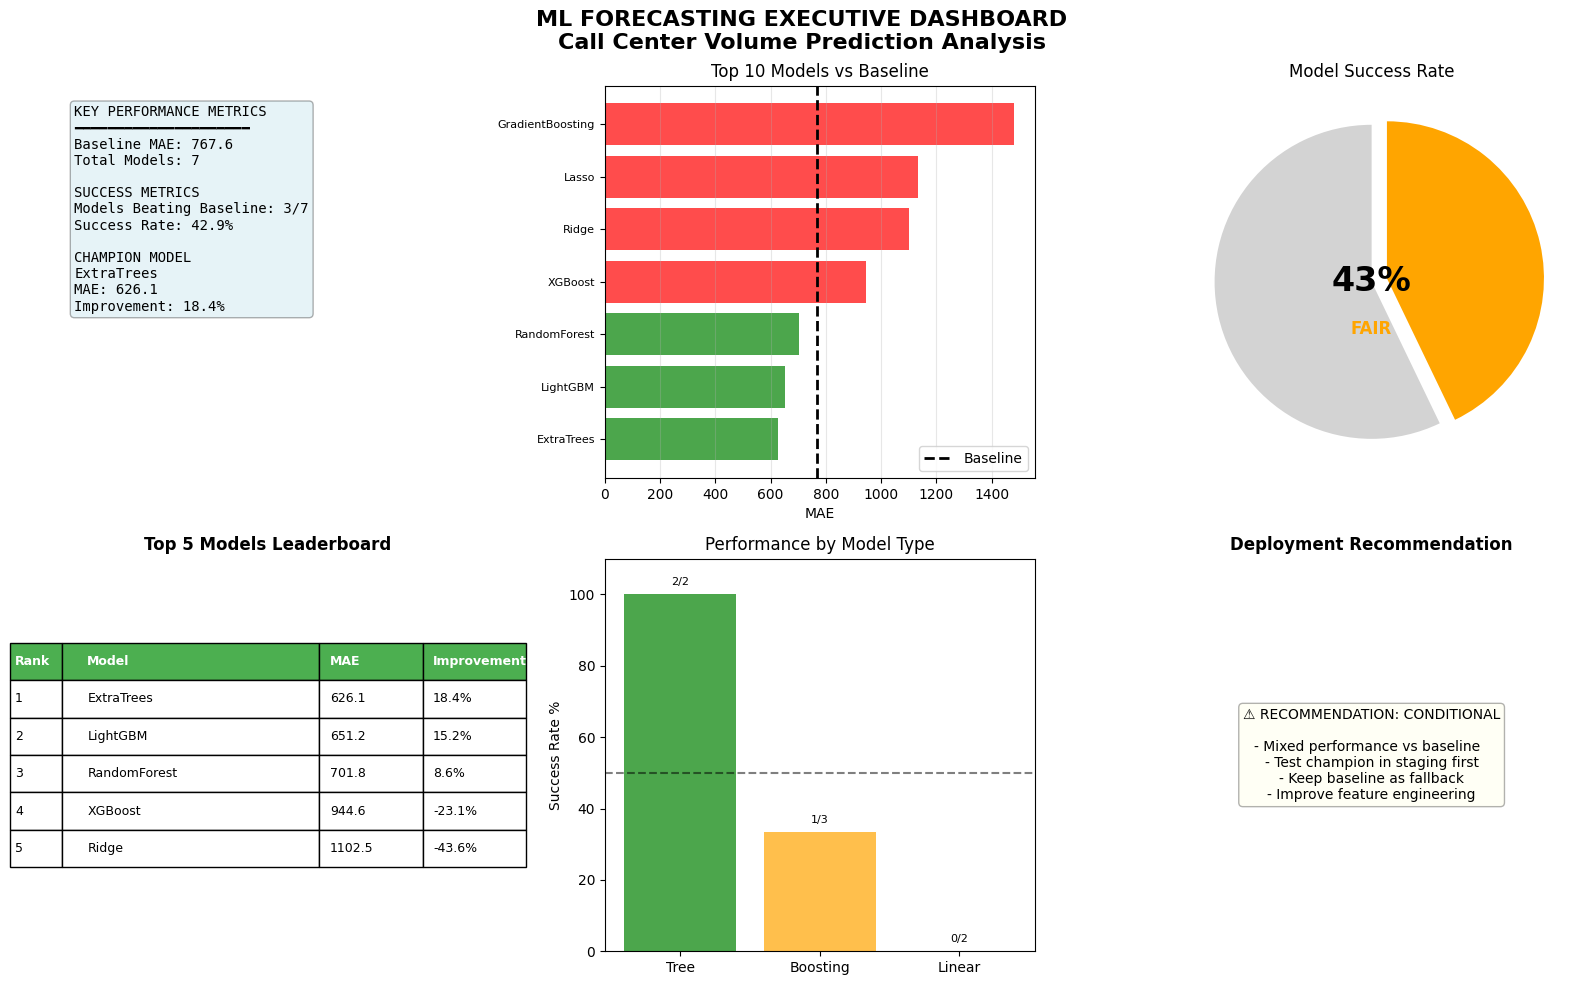


EXECUTIVE REPORT
Generated: 2025-09-23 21:02:25

SUMMARY
----------------------------------------
• Baseline Performance: MAE = 767.6
• Models Evaluated: 7
• Models Beating Baseline: 3 (42.9%)
• Champion Model: ExtraTrees
• Champion Performance: MAE = 626.1 (18.4% improvement)

TOP 5 MODELS
----------------------------------------
1. ✅ ExtraTrees: MAE = 626.1 (+18.4%)
2. ✅ LightGBM: MAE = 651.2 (+15.2%)
3. ✅ RandomForest: MAE = 701.8 (+8.6%)
4. ❌ XGBoost: MAE = 944.6 (-23.1%)
5. ❌ Ridge: MAE = 1102.5 (-43.6%)

MODEL TYPE SUMMARY
----------------------------------------
• Tree: 2/2 models beat baseline (100%)
• Boosting: 1/3 models beat baseline (33%)
• Linear: 0/2 models beat baseline (0%)

RECOMMENDATION
----------------------------------------
⚠️ Test in staging environment first

✅ EXECUTIVE SUMMARY COMPLETE

💾 Results saved to: final_ml_results_20250923_210225.csv
📊 Dashboard saved to: ml_dashboard_20250923_210225.png


In [20]:
# ============================================================================
# EXECUTIVE SUMMARY - FIXED VERSION
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("=" * 80)
print("📊 GENERATING EXECUTIVE SUMMARY")
print("=" * 80)

# Load your actual data and results
data = pd.read_csv("enhanced_eda_data.csv")
if "Date" in data.columns:
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date").sort_index()

# Calculate seasonal baseline
target = data["calls"]
train_size = int(len(target) * 0.75)
train_data = target.iloc[:train_size]
test_data = target.iloc[train_size:]

seasonal_predictions = []
for i in range(len(test_data)):
    lookup_idx = train_size + i - 7
    if lookup_idx >= 0 and lookup_idx < len(target):
        seasonal_predictions.append(target.iloc[lookup_idx])
    else:
        seasonal_predictions.append(train_data.iloc[-1])

seasonal_predictions = np.array(seasonal_predictions)
baseline_mae = mean_absolute_error(test_data, seasonal_predictions)
baseline_rmse = np.sqrt(mean_squared_error(test_data, seasonal_predictions))

# Load ML results
ml_results = pd.read_csv("all_models_results_calls.csv")

# Prepare results dataframe with required columns
results_df = ml_results[ml_results['Status'] == 'Success'].copy()
results_df['MAE_Improvement'] = ((baseline_mae - results_df['MAE']) / baseline_mae) * 100
results_df['Beats_Baseline'] = results_df['MAE'] < baseline_mae
results_df = results_df.sort_values('MAE')

# Create executive dashboard
fig = plt.figure(figsize=(16, 10))
fig.suptitle('ML FORECASTING EXECUTIVE DASHBOARD\nCall Center Volume Prediction Analysis',
            fontsize=16, fontweight='bold')

# 1. KEY METRICS (top left)
ax1 = fig.add_subplot(2, 3, 1)
ax1.axis('off')

total_models = len(results_df)
winners = results_df['Beats_Baseline'].sum()
win_rate = (winners / total_models) * 100 if total_models > 0 else 0
best_model = results_df.iloc[0] if len(results_df) > 0 else None

# FIXED: Proper formatting
if best_model is not None:
    champion_name = best_model['Model']
    champion_mae = f"{best_model['MAE']:.1f}"
    champion_improvement = f"{best_model['MAE_Improvement']:.1f}"
else:
    champion_name = "None"
    champion_mae = "N/A"
    champion_improvement = "N/A"

metrics_text = f"""KEY PERFORMANCE METRICS
━━━━━━━━━━━━━━━━━━━━━
Baseline MAE: {baseline_mae:.1f}
Total Models: {total_models}

SUCCESS METRICS
Models Beating Baseline: {winners}/{total_models}
Success Rate: {win_rate:.1f}%

CHAMPION MODEL
{champion_name}
MAE: {champion_mae}
Improvement: {champion_improvement}%"""

ax1.text(0.05, 0.95, metrics_text, transform=ax1.transAxes,
        fontsize=10, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))

# 2. MODEL PERFORMANCE COMPARISON (top center)
ax2 = fig.add_subplot(2, 3, 2)
if len(results_df) > 0:
    top_models = results_df.head(10)
    colors = ['green' if x else 'red' for x in top_models['Beats_Baseline']]
    bars = ax2.barh(range(len(top_models)), top_models['MAE'], color=colors, alpha=0.7)
    ax2.set_yticks(range(len(top_models)))
    ax2.set_yticklabels([m[:20] for m in top_models['Model']], fontsize=8)
    ax2.axvline(x=baseline_mae, color='black', linestyle='--', label='Baseline', linewidth=2)
    ax2.set_xlabel('MAE')
    ax2.set_title('Top 10 Models vs Baseline')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='x')

# 3. SUCCESS RATE GAUGE (top right)
ax3 = fig.add_subplot(2, 3, 3)
if win_rate >= 60:
    color = 'green'
    status = 'GOOD'
elif win_rate >= 40:
    color = 'orange'
    status = 'FAIR'
else:
    color = 'red'
    status = 'POOR'

# Create a pie chart as gauge
sizes = [win_rate, 100-win_rate]
colors_pie = [color, 'lightgray']
explode = (0.1, 0)
ax3.pie(sizes, explode=explode, colors=colors_pie, autopct='',
        startangle=90, counterclock=False)
ax3.text(0, 0, f'{win_rate:.0f}%', ha='center', va='center',
         fontsize=24, fontweight='bold')
ax3.text(0, -0.3, status, ha='center', va='center',
         fontsize=12, fontweight='bold', color=color)
ax3.set_title('Model Success Rate')

# 4. TOP 5 MODELS TABLE (bottom left)
ax4 = fig.add_subplot(2, 3, 4)
ax4.axis('tight')
ax4.axis('off')

if len(results_df) > 0:
    table_data = [['Rank', 'Model', 'MAE', 'Improvement']]
    for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
        model_name = row['Model'][:25] + '...' if len(row['Model']) > 25 else row['Model']
        table_data.append([
            str(i),
            model_name,
            f"{row['MAE']:.1f}",
            f"{row['MAE_Improvement']:.1f}%"
        ])

    table = ax4.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.1, 0.5, 0.2, 0.2])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 2)

    # Color header
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

ax4.set_title('Top 5 Models Leaderboard', fontweight='bold')

# 5. MODEL TYPE ANALYSIS (bottom center)
ax5 = fig.add_subplot(2, 3, 5)
model_types = {
    'Tree': ['Forest', 'Extra', 'Tree'],
    'Boosting': ['Gradient', 'XGBoost', 'LightGBM'],
    'Linear': ['Ridge', 'Lasso', 'Elastic'],
    'Other': ['SVR', 'Neighbor', 'Kernel', 'MLP']
}

type_performance = []
for category, keywords in model_types.items():
    cat_models = results_df[results_df['Model'].str.contains('|'.join(keywords), case=False, na=False)]
    if len(cat_models) > 0:
        type_performance.append({
            'Type': category,
            'Win_Rate': (cat_models['Beats_Baseline'].sum() / len(cat_models)) * 100,
            'Count': len(cat_models),
            'Winners': cat_models['Beats_Baseline'].sum()
        })

if type_performance:
    type_df = pd.DataFrame(type_performance).sort_values('Win_Rate', ascending=False)
    colors = ['green' if x >= 50 else 'orange' if x > 0 else 'red' for x in type_df['Win_Rate']]
    bars = ax5.bar(type_df['Type'], type_df['Win_Rate'], color=colors, alpha=0.7)
    ax5.axhline(y=50, color='black', linestyle='--', alpha=0.5, label='50% threshold')
    ax5.set_ylabel('Success Rate %')
    ax5.set_title('Performance by Model Type')
    ax5.set_ylim(0, 110)

    # Add count labels
    for bar, (_, row) in zip(bars, type_df.iterrows()):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{row["Winners"]}/{row["Count"]}',
                ha='center', va='bottom', fontsize=8)

# 6. RECOMMENDATIONS (bottom right)
ax6 = fig.add_subplot(2, 3, 6)
ax6.axis('off')

if win_rate >= 60:
    rec_text = """✅ RECOMMENDATION: DEPLOY

- ML significantly outperforms baseline
- Deploy champion model to production
- Monitor performance daily
- Set up retraining pipeline"""
    rec_color = 'lightgreen'
elif win_rate >= 40:
    rec_text = """⚠️ RECOMMENDATION: CONDITIONAL

- Mixed performance vs baseline
- Test champion in staging first
- Keep baseline as fallback
- Improve feature engineering"""
    rec_color = 'lightyellow'
else:
    rec_text = """❌ RECOMMENDATION: HOLD

- Limited improvement over baseline
- Continue model development
- Review data quality
- Consider ensemble approaches"""
    rec_color = 'lightcoral'

ax6.text(0.5, 0.5, rec_text, transform=ax6.transAxes,
        fontsize=10, ha='center', va='center',
        bbox=dict(boxstyle='round', facecolor=rec_color, alpha=0.3))
ax6.set_title('Deployment Recommendation', fontweight='bold')

plt.tight_layout()
plt.show()

# Generate text report
print("\n" + "=" * 80)
print("EXECUTIVE REPORT")
print("=" * 80)
print(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

print("SUMMARY")
print("-" * 40)
print(f"• Baseline Performance: MAE = {baseline_mae:.1f}")
print(f"• Models Evaluated: {total_models}")
print(f"• Models Beating Baseline: {winners} ({win_rate:.1f}%)")
if best_model is not None:
    print(f"• Champion Model: {best_model['Model']}")
    print(f"• Champion Performance: MAE = {best_model['MAE']:.1f} ({best_model['MAE_Improvement']:.1f}% improvement)")

print("\nTOP 5 MODELS")
print("-" * 40)
for i, (_, row) in enumerate(results_df.head(5).iterrows(), 1):
    status_icon = "✅" if row['Beats_Baseline'] else "❌"
    print(f"{i}. {status_icon} {row['Model']}: MAE = {row['MAE']:.1f} ({row['MAE_Improvement']:+.1f}%)")

print("\nMODEL TYPE SUMMARY")
print("-" * 40)
if type_performance:
    for entry in sorted(type_performance, key=lambda x: x['Win_Rate'], reverse=True):
        print(f"• {entry['Type']}: {entry['Winners']}/{entry['Count']} models beat baseline ({entry['Win_Rate']:.0f}%)")

print("\nRECOMMENDATION")
print("-" * 40)
if win_rate >= 60:
    print("✅ Deploy champion model with monitoring")
elif win_rate >= 40:
    print("⚠️ Test in staging environment first")
else:
    print("❌ Continue development, use baseline for now")

print("\n" + "=" * 80)
print("✅ EXECUTIVE SUMMARY COMPLETE")
print("=" * 80)

# Save results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
results_filename = f'final_ml_results_{timestamp}.csv'
results_df.to_csv(results_filename, index=False)
print(f"\n💾 Results saved to: {results_filename}")

# Save the figure
fig.savefig(f'ml_dashboard_{timestamp}.png', dpi=150, bbox_inches='tight')
print(f"📊 Dashboard saved to: ml_dashboard_{timestamp}.png")

In [17]:
### YOU DONT NEED THIS #####

In [18]:
# ============================================================================
# DIAGNOSTIC VERSION - VERIFY GRIDSEARCHCV IS ACTUALLY RUNNING
# ============================================================================

import pandas as pd
import numpy as np
import time
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

def diagnostic_gridsearch_test():
    """Test to verify GridSearchCV is actually running and taking time"""

    print("="*80)
    print("DIAGNOSTIC TEST - VERIFYING GRIDSEARCHCV EXECUTION")
    print("="*80)

    # Create synthetic data
    print("\n1. Creating test data...")
    np.random.seed(42)
    X = np.random.randn(300, 20)  # 300 samples, 20 features
    y = np.random.randn(300)

    # Split data
    train_size = int(len(X) * 0.75)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]

    print(f"   Train shape: {X_train.shape}")
    print(f"   Test shape: {X_test.shape}")

    # Define parameter grid
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [5, 10, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Calculate total combinations
    total_combinations = 3 * 3 * 3 * 3  # 81 combinations
    cv_splits = 5
    total_fits = total_combinations * cv_splits  # 405 fits

    print(f"\n2. Parameter grid:")
    print(f"   Combinations: {total_combinations}")
    print(f"   CV splits: {cv_splits}")
    print(f"   Total fits required: {total_fits}")
    print(f"   This SHOULD take 30-60 seconds...")

    # Create model and GridSearchCV
    rf = RandomForestRegressor(random_state=42, n_jobs=1)  # Single thread to see timing
    tscv = TimeSeriesSplit(n_splits=cv_splits)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=tscv,
        scoring='neg_mean_absolute_error',
        verbose=2,  # VERBOSE=2 shows each fit
        n_jobs=1,   # Single thread to see real timing
        return_train_score=True
    )

    # TIME THE GRIDSEARCH
    print(f"\n3. Starting GridSearchCV at {pd.Timestamp.now().strftime('%H:%M:%S')}...")
    print("   You should see progress output below:")
    print("-"*60)

    start_time = time.time()

    # FIT - THIS SHOULD TAKE TIME AND SHOW PROGRESS
    grid_search.fit(X_train, y_train)

    fit_time = time.time() - start_time

    print("-"*60)
    print(f"\n4. GridSearchCV completed at {pd.Timestamp.now().strftime('%H:%M:%S')}")
    print(f"   Time taken: {fit_time:.1f} seconds")
    print(f"   Fits performed: {len(grid_search.cv_results_['params'])}")
    print(f"   Best score: {-grid_search.best_score_:.4f}")
    print(f"   Best params: {grid_search.best_params_}")

    # Verify it actually searched multiple parameters
    unique_scores = len(set(grid_search.cv_results_['mean_test_score']))
    print(f"\n5. Verification:")
    print(f"   Unique scores found: {unique_scores} (should be >1 if search worked)")
    print(f"   Time per fit: {fit_time/total_fits:.3f} seconds")

    if fit_time < 5:
        print("\n⚠️ WARNING: GridSearch completed too fast!")
        print("   Either:")
        print("   - GridSearchCV isn't actually running")
        print("   - Your machine is extremely fast")
        print("   - Something is wrong with the implementation")
    elif unique_scores == 1:
        print("\n⚠️ WARNING: All parameter combinations gave same score!")
        print("   GridSearch may not be working properly")
    else:
        print("\n✅ GridSearchCV is working correctly!")

    return grid_search

# RUN THE DIAGNOSTIC TEST
print("Running diagnostic test...")
print("This should take 30-60 seconds if GridSearchCV is working properly")
print()

diagnostic_result = diagnostic_gridsearch_test()

# Now test with your actual data
print("\n" + "="*80)
print("NOW TESTING WITH YOUR ACTUAL PIPELINE")
print("="*80)

# Check if your data loading functions exist
try:
    # Try to load your data
    print("\nChecking if data loading functions exist...")
    data = load_all_data_columns(CSV_FILE_PATH, TARGET_COLUMN, DATE_COLUMN)
    print(f"✅ Data loaded: {data.shape}")

    X, y = create_all_features(data, TARGET_COLUMN)
    print(f"✅ Features created: {X.shape}")

    print("\nYour pipeline SHOULD work, but with this data size:")
    print(f"  Training samples: {int(len(X)*0.75)}")
    print(f"  Features: {X.shape[1]}")
    print("  Expected time: 15-30 minutes for 30 models with GridSearchCV")

except NameError as e:
    print(f"❌ ERROR: {str(e)}")
    print("\nFunctions 'load_all_data_columns' and 'create_all_features' are NOT defined!")
    print("These must be defined in earlier cells or the pipeline will fail.")
    print("\nMake sure to run the cells that define:")
    print("  - load_all_data_columns()")
    print("  - create_all_features()")
except FileNotFoundError:
    print(f"❌ ERROR: CSV file '{CSV_FILE_PATH}' not found!")
except Exception as e:
    print(f"❌ ERROR: {str(e)}")

Running diagnostic test...
This should take 30-60 seconds if GridSearchCV is working properly

DIAGNOSTIC TEST - VERIFYING GRIDSEARCHCV EXECUTION

1. Creating test data...
   Train shape: (225, 20)
   Test shape: (75, 20)

2. Parameter grid:
   Combinations: 81
   CV splits: 5
   Total fits required: 405
   This SHOULD take 30-60 seconds...

3. Starting GridSearchCV at 20:59:25...
   You should see progress output below:
------------------------------------------------------------
Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_sp